# BETA Mixed Effects Models
Created: 08/08/24 \
Updated: 08/14/2024 

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08142024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



subj_id  bdi
0    MS002   14
1    MS003    8
2    MS009   16
3    MS011   13
4    MS015   26
5    MS016   10
6    MS017   26
7    MS019   12
8    MS022   10
9    MS024   16
10   MS025   10
11   MS026    9
12   MS027   22
13   MS028   13
14   MS029   32
15   MS030   19
16   MS033   39
17   MS035   15
18   MS041   10
19   MS043   23
20   MS048   19
21   MS050    9
22     DA8   13
23   DA023   14
24   DA026   19
25   DA037    4
26   DA039   22

In [7]:
#### set theme for all plots
# %matplotlib inline
# from matplotlib import rc
# rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("talk")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load Regression DF

In [8]:
band = 'beta'

In [9]:
band_df = pd.read_csv(f'{save_dir}{band}_master_df.csv')
band_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [10]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [11]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [12]:
#### filter df by rois with electrode counts >= 50 *** updated to >15
keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
).values>=20].tolist()

# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
# keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']     
keep_rois


['dmpfc',
 'ofc',
 'acc',
 'sts',
 'hpc',
 'amy',
 'dlpfc',
 'stg',
 'vlpfc',
 'ains',
 'smg',
 'pins',
 'thalamus',
 'mtg',
 'temporal pole',
 'mcc',
 'motor',
 'phg',
 'parietal',
 'vmpfc']

In [13]:
####### NEW DATA FRAME 
reg_df = band_df.copy()
reg_df = reg_df[reg_df.roi.isin(keep_rois)]
len(reg_df)

244136

In [14]:
np.max(reg_df.band_pow)

6.032583972049991

In [15]:
np.min(reg_df.band_pow)

-0.9714854334507784

# POW ~ Outcome Vars Regressions

In [19]:
# ###### BIC Testing - 
# final_vars   = ['decisionCPE'] # BIC -75963.84280269922
# final_vars   = ['RPE','decisionCPE'] # -76067.74855549095
# final_vars   = ['TrialEV','RPE','decisionCPE'] # -76133.12655751391
# final_vars   = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE'] # -77928.39857466736
# final_vars   = ['C(TrialType)','TrialEV', 'TotalProfit', 'decisionCPE'] # -76748.27878718339
# final_vars   = ['C(GambleChoice)', 'TrialEV','TotalProfit', 'decisionCPE'] # -77886.00117049165
# final_vars   = ['C(GambleChoice)', 'TrialEV', 'decisionCPE'] # -77162.6616648732
# final_vars   = ['TrialEV', 'TotalProfit', 'decisionCPE'] # -76744.26232072695
# final_vars   = ['C(GambleChoice)', 'decisionCPE'] # -77189.27434340885
# final_vars   = ['TotalProfit', 'decisionCPE'] # -76671.9713105091
# final_vars   = ['TrialEV', 'decisionCPE'] # -76046.95446374474
# final_vars   = ['C(TrialType)','decisionCPE'] # -76024.04129696668
# final_vars   = ['C(TrialType)','TotalProfit', 'decisionCPE'] # -76711.13190240585
# final_vars   = ['C(TrialType)','TrialEV',  'decisionCPE'] # -76066.75006845719


In [17]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

In [18]:
final_vars   = ['C(GambleChoice)', 'TrialEV','TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic    

                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          band_pow  
No. Observations:            244112           Method:                      ML        
No. Groups:                  1776             Scale:                       0.0408    
Min. group size:             65               Log-Likelihood:              39073.2571
Max. group size:             148              Converged:                   Yes       
Mean group size:             137.5                                                   
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.053    0.003 -20.722 0.000 -0.058 -0.048
C(GambleChoice)[T.safe]                   -0.005    0.001  -3.626 0.000 -0.008

-77886.00117049165


# ROI REGRESSIONS
- test all ROIs & see which ROIs are significant
- correlate bdi with ROI beta coefficients 


In [20]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
final_vars   = ['C(GambleChoice)','TrialEV','TotalProfit','decisionCPE']

In [21]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        final_vars,outcome_var,rand_eff_var,reml=False) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [22]:
roi_fit_results['band'] = band
roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

In [23]:
raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=9.62359192126957, pvalue=3.867028094071353e-18, df=192),
 'dmpfc': TtestResult(statistic=9.515595449513198, pvalue=3.854812332770651e-18, df=215),
 'amy': TtestResult(statistic=4.35136812076282, pvalue=3.0009436526254624e-05, df=112),
 'sts': TtestResult(statistic=-4.451418610790201, pvalue=1.628956996822001e-05, df=154),
 'ains': TtestResult(statistic=11.654878752419913, pvalue=4.679580568351799e-18, df=70),
 'vlpfc': TtestResult(statistic=8.546319913996719, pvalue=6.270505803586954e-13, df=81),
 'hpc': TtestResult(statistic=0.8271200333542481, pvalue=0.40963951171994906, df=134),
 'mtg': TtestResult(statistic=-5.009534001367279, pvalue=5.78879285688765e-06, df=56),
 'ofc': TtestResult(statistic=8.473304058505832, pvalue=5.049111965803942e-15, df=201),
 'pins': TtestResult(statistic=6.712782969322457, pvalue=8.272107751501816e-09, df=59),
 'dlpfc': TtestResult(statistic=6.788187118962318, pvalue=6.763952471441322e-10, df=106),
 'motor': TtestResult(statis

In [24]:
roi_fit_results

unique_reref_ch subj_id       roi  bdi  raw_Intercept  \
0           DA023_lac1-lac2   DA023       acc   14       0.008821   
1           DA023_lac2-lac3   DA023       acc   14       0.012320   
2           DA023_lac3-lac4   DA023       acc   14       0.009223   
3       MS002_lacas1-lacas2   MS002       acc   14       0.025398   
4       MS002_lacas2-lacas3   MS002       acc   14       0.002349   
...                     ...     ...       ...  ...            ...   
1771  MS050_lcmang3-lcmang4   MS050  thalamus    9       0.011630   
1772  MS050_lcmang4-lcmang5   MS050  thalamus    9       0.017397   
1773  MS050_rcmsmg1-rcmsmg2   MS050  thalamus    9       0.011963   
1774  MS050_rcmsmg2-rcmsmg3   MS050  thalamus    9       0.009769   
1775  MS050_rcmsmg3-rcmsmg4   MS050  thalamus    9      -0.021056   

      raw_GambleChoice  raw_TrialEV  raw_TotalProfit  raw_decisionCPE  \
0            -0.019932     0.002223        -0.011230         0.007151   
1            -0.004611    -0.006981         0.013845        -0.005091   
2            -0.002647    -0.003692         0.004785        -0.002689   
3            -0.023713     0.008948         0.013541         0.014771   
4             0.013979     0.001369         0.014037         0.008953   
...                ...          ...              ...              ...   
1771         -0.007046    -0.002037        -0.005841         0.002695   
1772          0.010288     0.012430        -0.016949        -0.008583   
1773          0.013797     0.009607        -0.001646        -0.005015   
1774         -0.017888    -0.012898         0.001505         0.009046   
1775          0.014706     0.011164        -0.007654        -0.012857   

      Intercept  GambleChoice   TrialEV  TotalProfit  decisionCPE  band  
0      0.003642     -0.032425  0.005496    -0.010194     0.014319  beta  
1      0.007140     -0.017104 -0.003708     0.014881     0.002077  beta  
2      0.004043     -0.015140 -0.000419     0.005821     0.004479  beta  
3      0.020218     -0.036206  0.012221     0.014577     0.021939  beta  
4     -0.002831      0.001486  0.004641     0.015073     0.016121  beta  
...         ...           ...       ...          ...          ...   ...  
1771  -0.005172     -0.004710  0.014402     0.007593     0.016718  beta  
1772   0.000595      0.012625  0.028869    -0.003514     0.005439  beta  
1773  -0.004839      0.016134  0.026045     0.011788     0.009008  beta  
1774  -0.007032     -0.015551  0.003540     0.014939     0.023068  beta  
1775  -0.037857      0.017042  0.027603     0.005780     0.001166  beta  

[1776 rows x 15 columns]

In [25]:
fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
# fe_params_pvals = {f'{roi}':roi_fit_dict[roi].pvalues for roi in list(roi_fit_dict.keys())}


In [26]:
fe_results = []
for fe_res in fe_params_results:
    
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))


In [27]:
fe_results = pd.concat(fe_results).reset_index(drop=True)

In [28]:
fe_results['roi_cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['decisionCPE'],4) for roi in fe_results.roi.tolist()]

In [30]:
fe_results

Intercept  C(GambleChoice)[T.safe]   TrialEV  TotalProfit  decisionCPE  \
0   -0.005180                -0.012493  0.003273     0.001036     0.007168   
1   -0.035581                -0.008979 -0.003294     0.010663     0.007822   
2   -0.090577                 0.009229  0.001078     0.011191     0.002202   
3   -0.070407                -0.026212  0.010891     0.009746    -0.005244   
4    0.020233                -0.015719  0.000784     0.009796     0.025027   
5   -0.029090                -0.013844 -0.000858     0.005622     0.013278   
6   -0.122107                 0.009181  0.004811    -0.005928     0.001439   
7   -0.096133                -0.025194  0.002145     0.007144    -0.013647   
8   -0.042171                 0.001608  0.002816     0.004540     0.006796   
9   -0.059945                 0.007357  0.010741     0.001899     0.019369   
10  -0.041592                -0.011040 -0.000599     0.012733     0.012048   
11  -0.065174                 0.002048  0.010481     0.026616     0.017140   
12  -0.127962                -0.010775  0.000306     0.000663     0.003353   
13  -0.090195                 0.007565  0.005557     0.002226    -0.006233   
14  -0.063796                 0.014857  0.014385     0.011097     0.001046   
15  -0.047557                 0.002346  0.000417    -0.002132    -0.001111   
16  -0.078324                 0.004893  0.002791    -0.023079    -0.002507   
17  -0.093182                -0.014867  0.004922     0.010236    -0.007859   
18  -0.128936                 0.009373  0.008442    -0.013975     0.019849   
19  -0.016801                 0.002337  0.016439     0.013434     0.014022   

              roi  roi_cpe_pval  
0             acc        0.0012  
1           dmpfc        0.0029  
2             amy        0.5439  
3             sts        0.1692  
4            ains        0.0000  
5           vlpfc        0.0019  
6             hpc        0.7151  
7             mtg        0.0265  
8             ofc        0.0081  
9            pins        0.0003  
10          dlpfc        0.0021  
11          motor        0.0703  
12          vmpfc        0.6694  
13            phg        0.3850  
14            smg        0.8329  
15            stg        0.7647  
16            mcc        0.7659  
17  temporal pole        0.2727  
18       parietal        0.0355  
19       thalamus        0.0189

In [35]:
# bonferr_alpha = 0.05/len(fe_results)
bonferr_alpha = 0.01

bonferr_alpha

0.01

In [36]:
sig_rois = fe_results.roi[fe_results.roi_cpe_pval <= bonferr_alpha].tolist()
sig_rois

['acc', 'dmpfc', 'ains', 'vlpfc', 'ofc', 'pins', 'dlpfc']

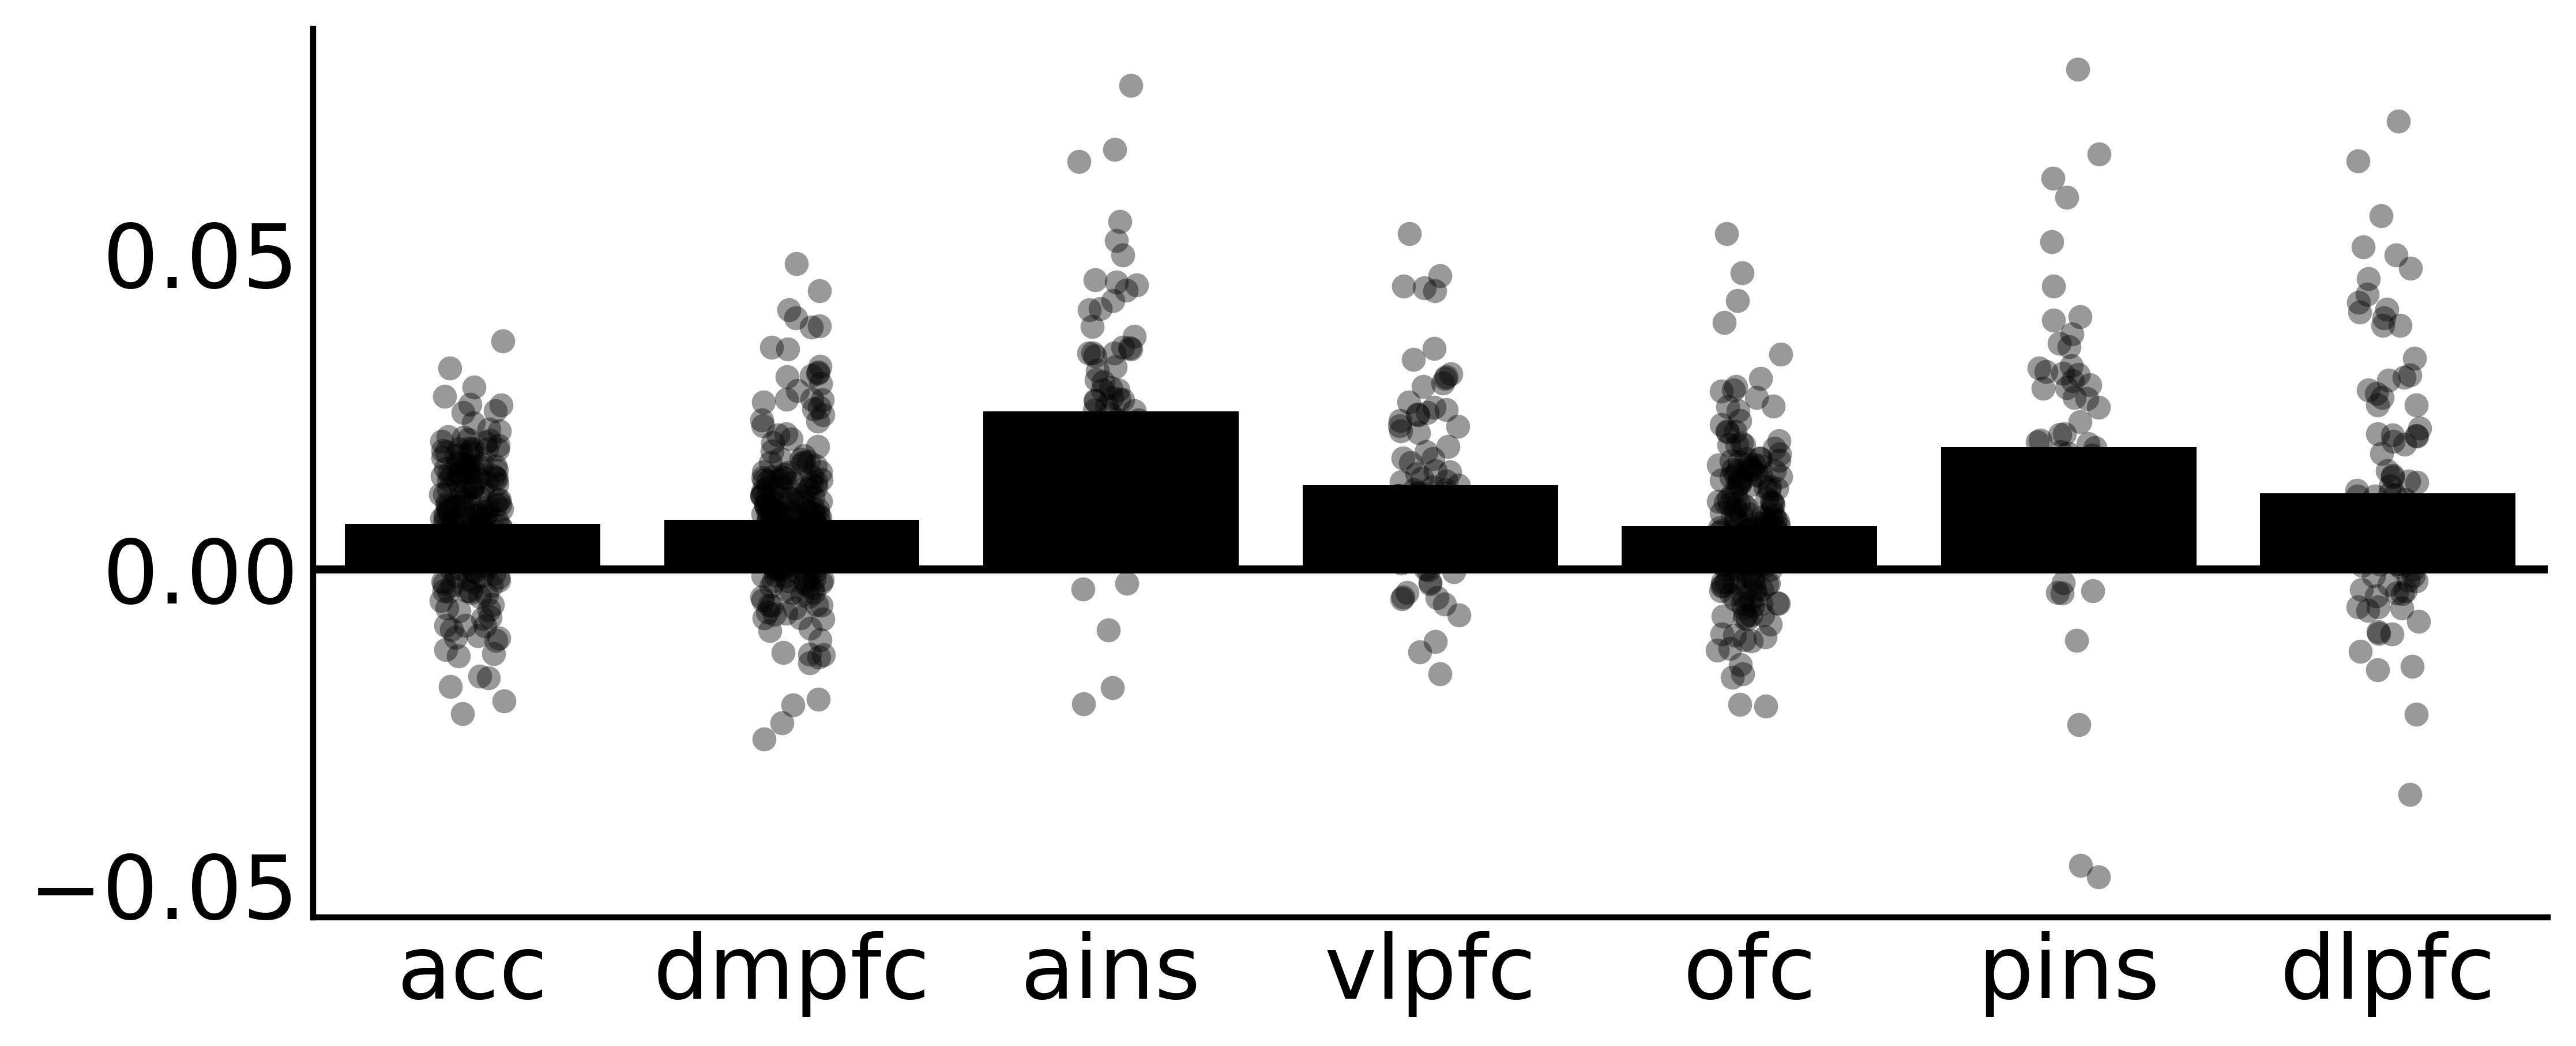

In [37]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=sig_rois)


#function info - 
# plot_roi_model_results(model_results,x_var,y_var,ylabel=None,color = 'k',bar_order=None,figsize=(10,4),dpi=500,linewidth=1.5,
#                            size=6,sns_context="poster",save_fig=False,save_dir=None,fig_id=None)


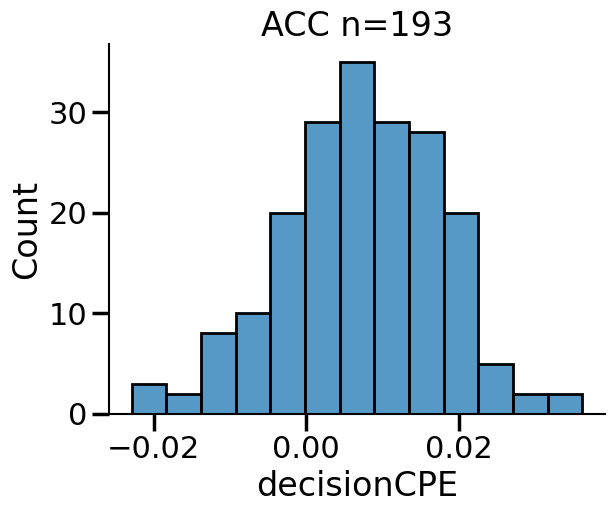

In [38]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
plt.title(f'ACC n={n}')

sns.despine()

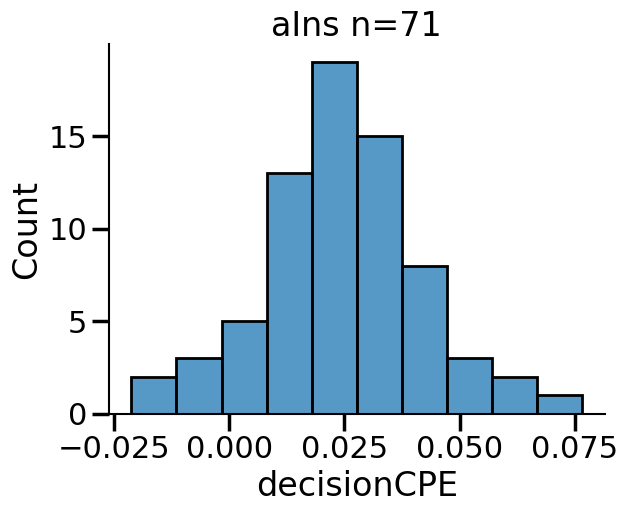

In [39]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'ains'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'ains'].decisionCPE)
plt.title(f'aIns n={n}')

sns.despine()

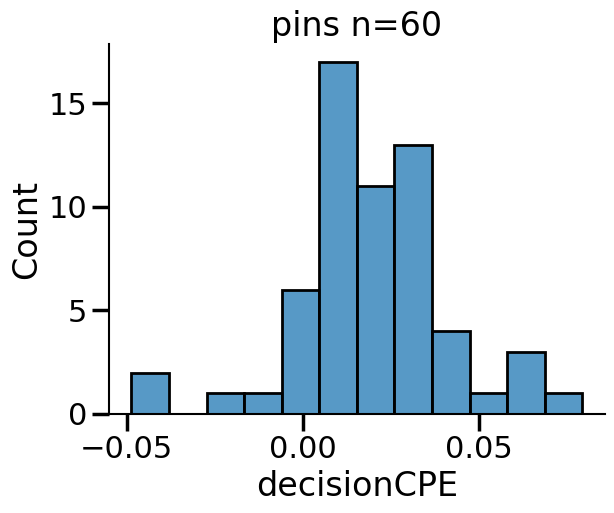

In [44]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'pins'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'pins'].decisionCPE)
plt.title(f'pins n={n}')

sns.despine()

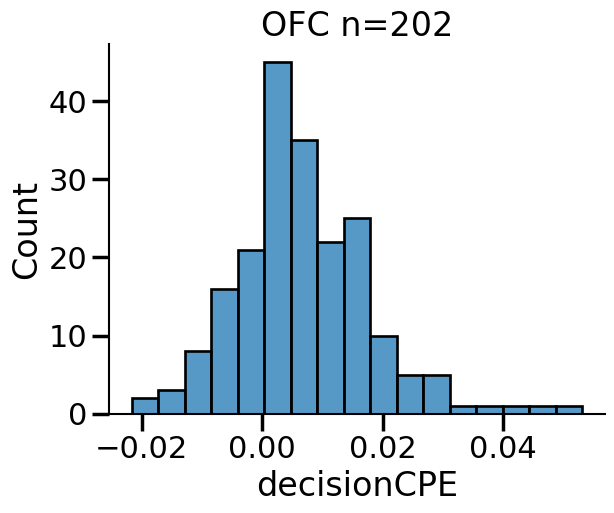

In [40]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'ofc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'ofc'].decisionCPE)
plt.title(f'OFC n={n}')

sns.despine()

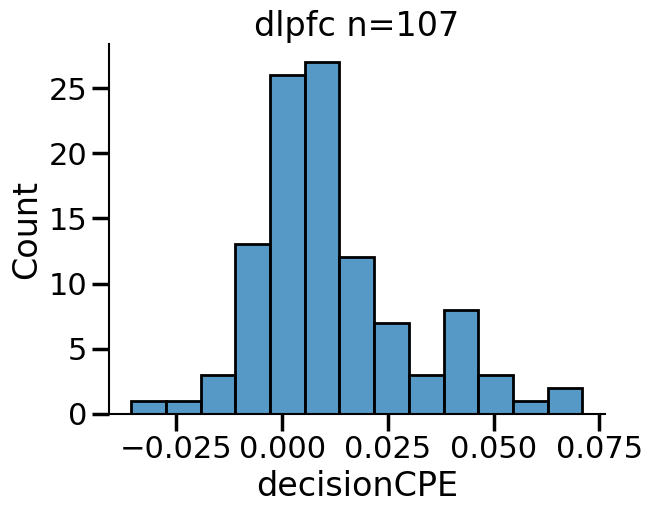

In [42]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'dlpfc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'dlpfc'].decisionCPE)
plt.title(f'dlpfc n={n}')

sns.despine()

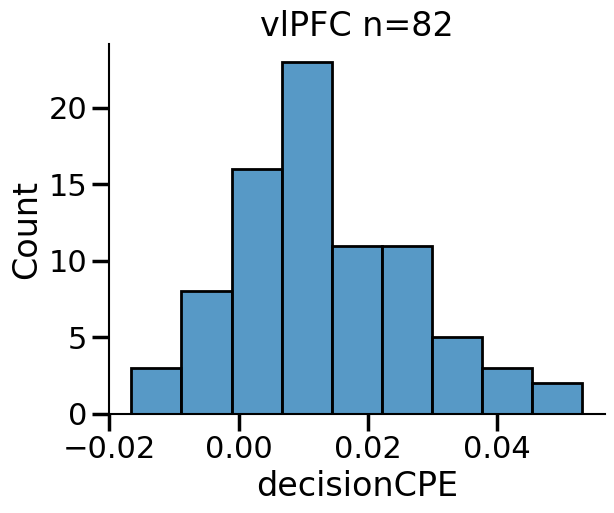

In [43]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'vlpfc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'vlpfc'].decisionCPE)
plt.title(f'vlPFC n={n}')

sns.despine()

In [45]:
sig_rois

['acc', 'dmpfc', 'ains', 'vlpfc', 'ofc', 'pins', 'dlpfc']

In [46]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr -0.22831287625966543 0.0014055657846894496
dmpfc pearsonr -0.16483980199615755 0.015300105152902558
amy pearsonr -0.5176383074282178 4.328767573375528e-09
sts pearsonr -0.004956805397124697 0.9511899175932288
ains pearsonr -0.41826340821801744 0.0002837482276148543
vlpfc pearsonr -0.16439997349008253 0.13996723888520637
hpc pearsonr -0.4411783057537205 8.522210741814667e-08
mtg pearsonr -0.3443882900420089 0.008709535909319562
ofc pearsonr -0.2588274487802914 0.0001997112367311565
pins pearsonr 0.12204823986242193 0.35290270556235925
dlpfc pearsonr -0.08883204361162454 0.36287867083531805
motor pearsonr -0.12428788858860741 0.5538996481789904
vmpfc pearsonr -0.1296652466689012 0.5554102461629122
phg pearsonr -0.10377230055733493 0.6215646726942764
smg pearsonr -0.06451405078496113 0.6068065654535996
stg pearsonr -0.1367455456283971 0.16422688893580337
mcc pearsonr -0.19329407573206564 0.3243691686605376
temporal pole pearsonr -0.40066389002794595 0.02550668500532148
pariet

In [48]:
sig_rho

[('acc', -0.22831287625966543, 0.0014055657846894496),
 ('dmpfc', -0.16483980199615755, 0.015300105152902558),
 ('amy', -0.5176383074282178, 4.328767573375528e-09),
 ('ains', -0.41826340821801744, 0.0002837482276148543),
 ('hpc', -0.4411783057537205, 8.522210741814667e-08),
 ('mtg', -0.3443882900420089, 0.008709535909319562),
 ('ofc', -0.2588274487802914, 0.0001997112367311565),
 ('temporal pole', -0.40066389002794595, 0.02550668500532148)]

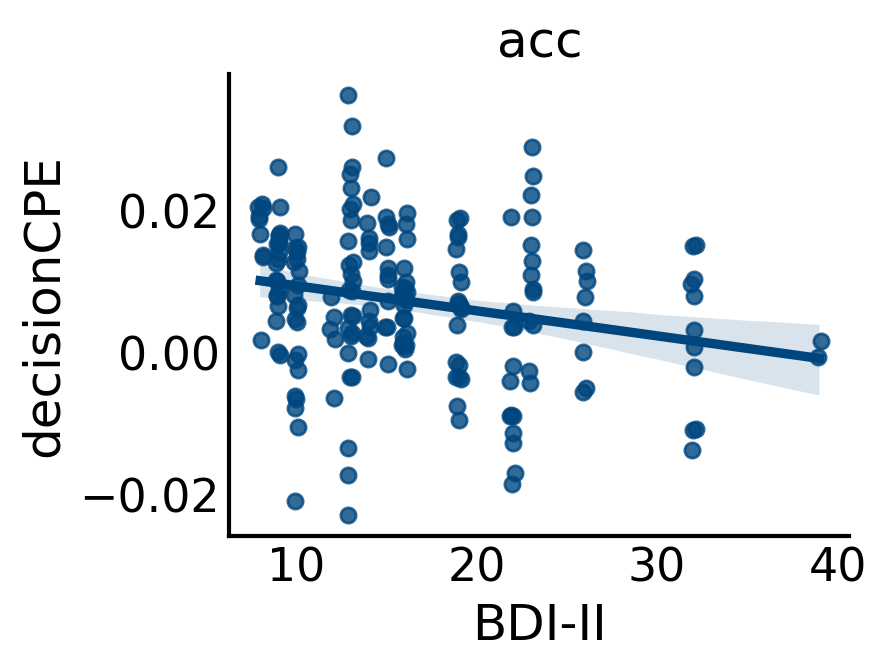

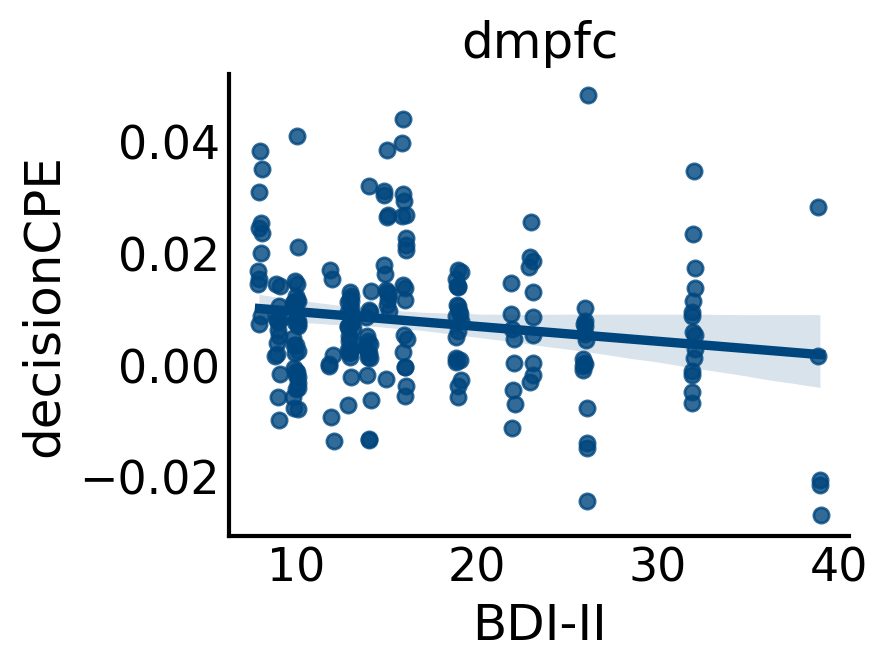

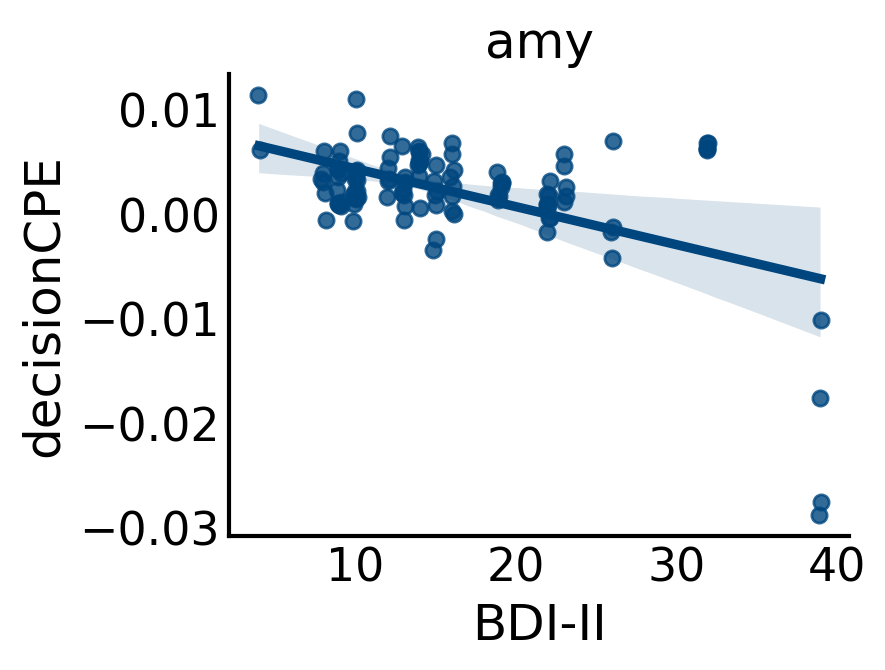

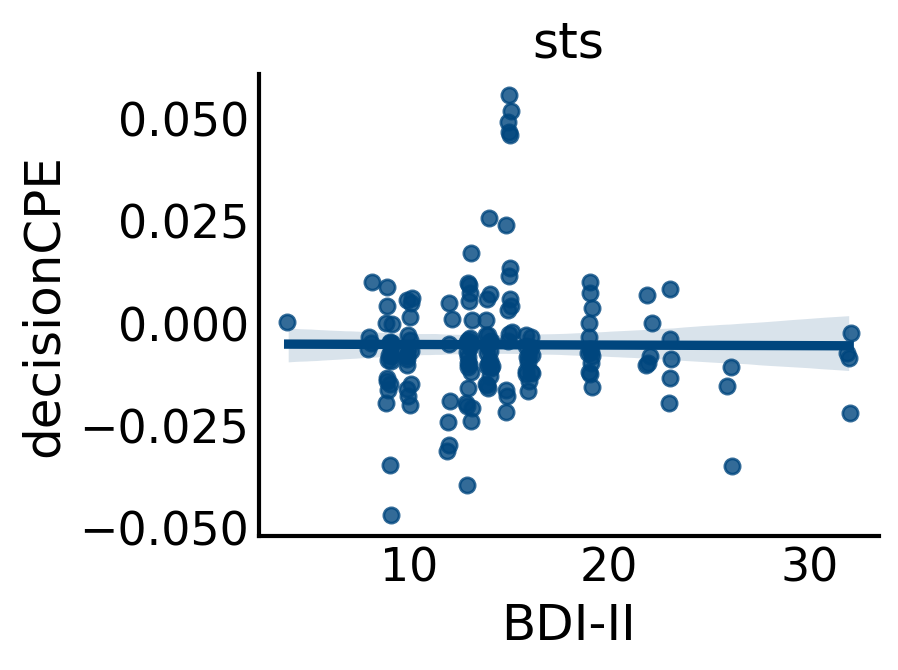

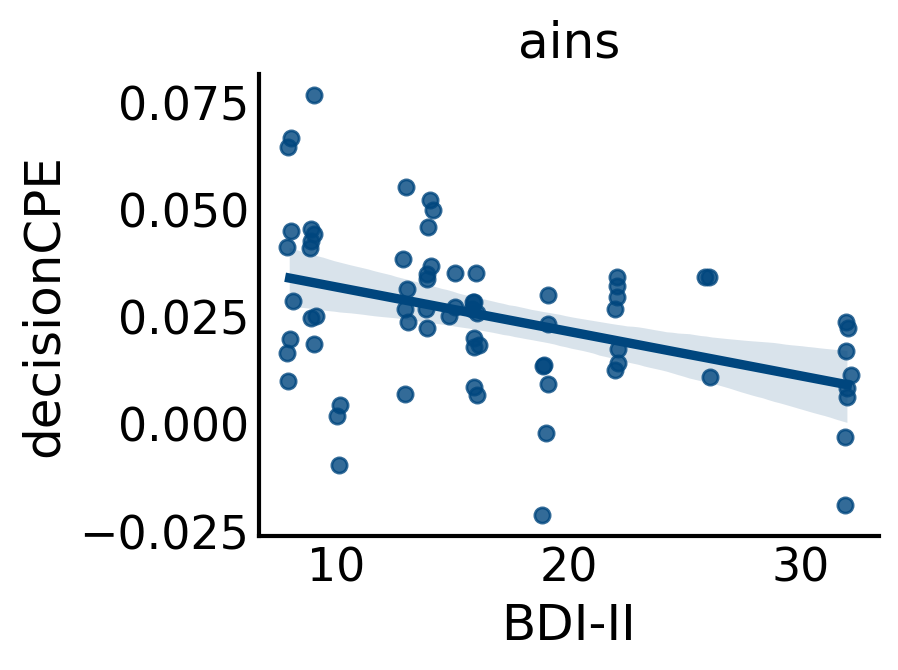

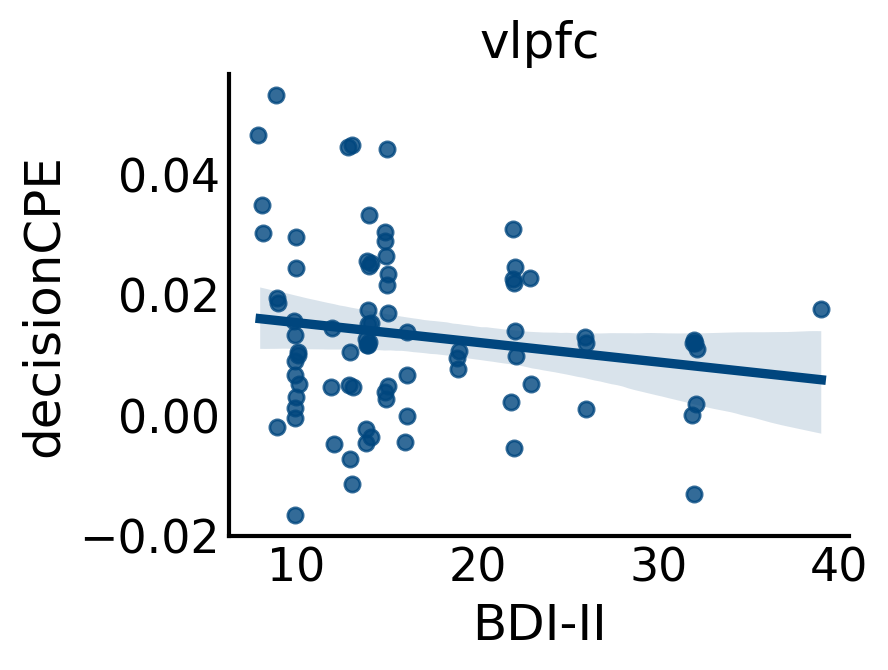

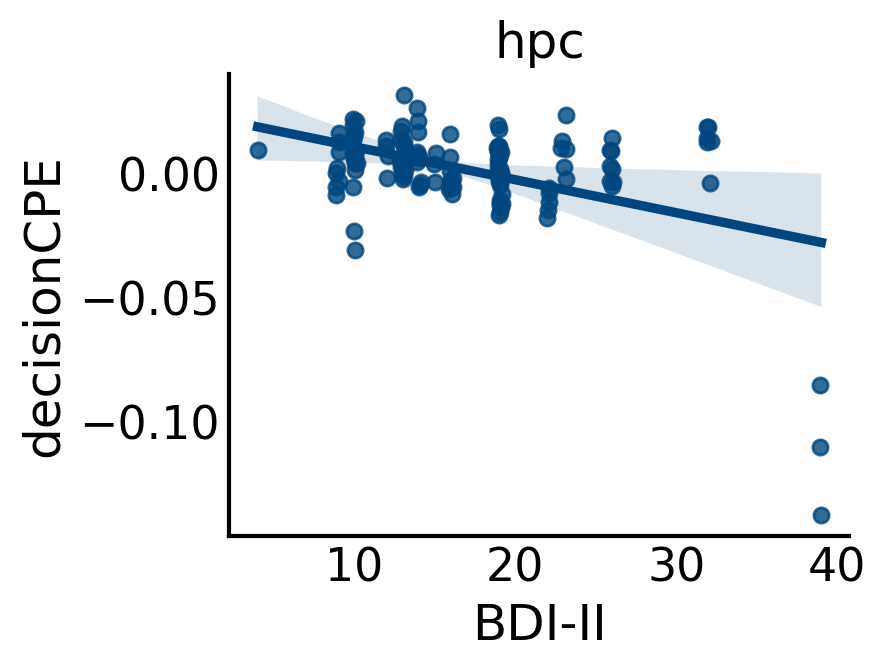

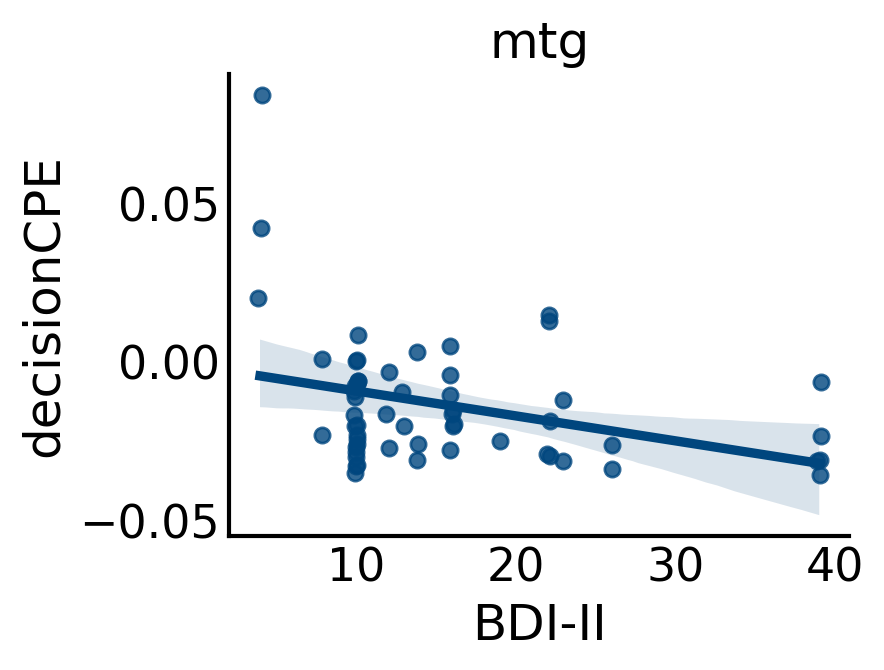

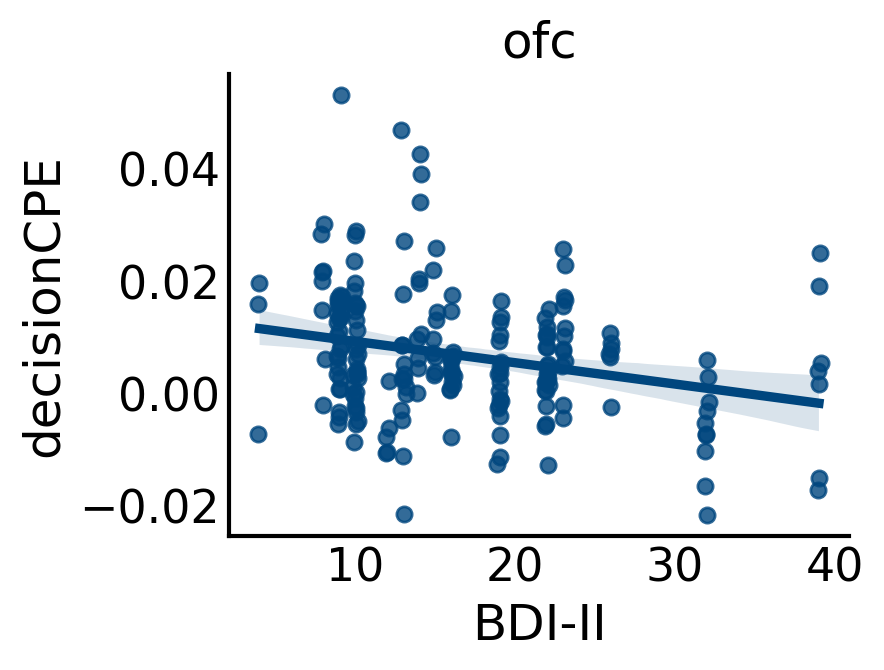

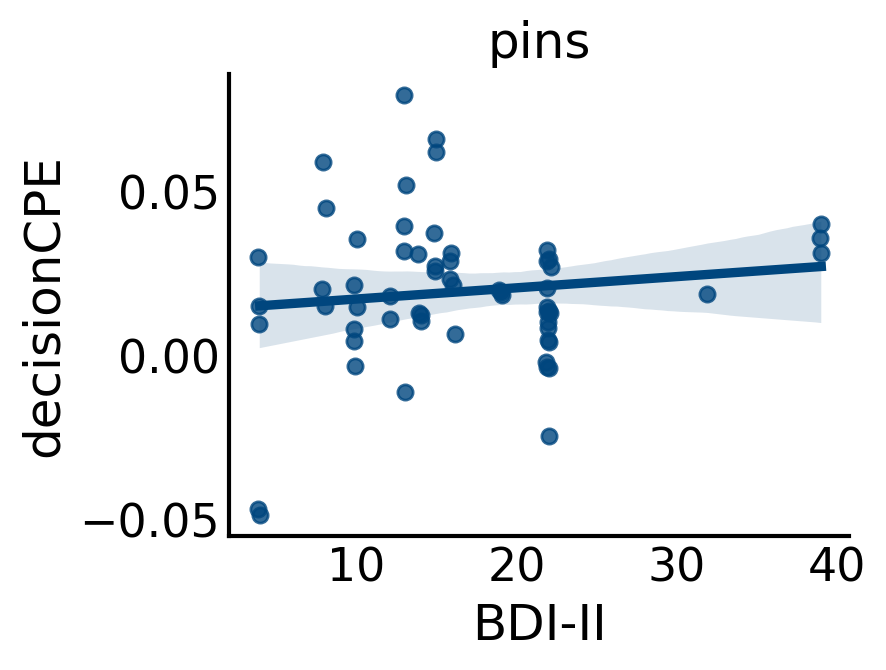

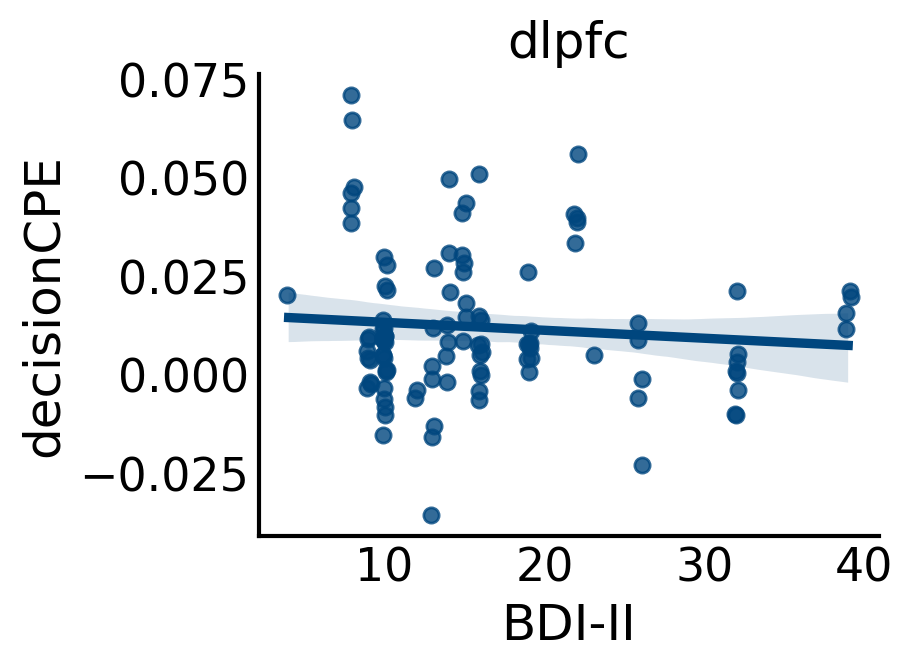

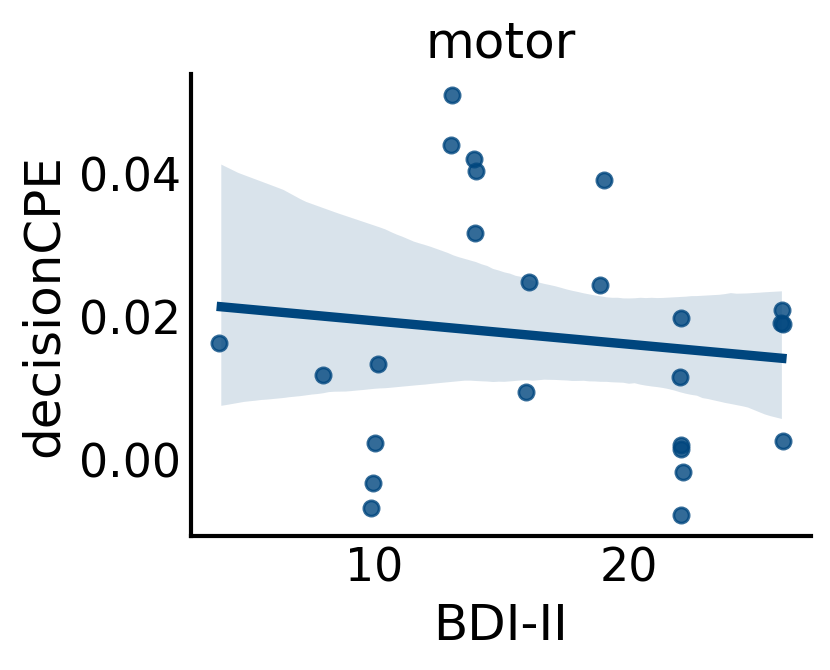

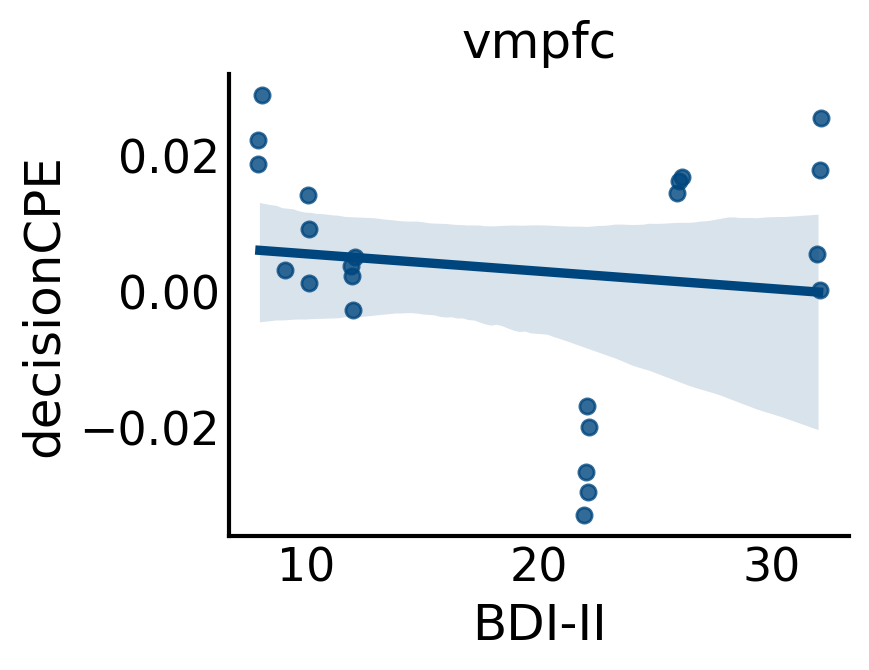

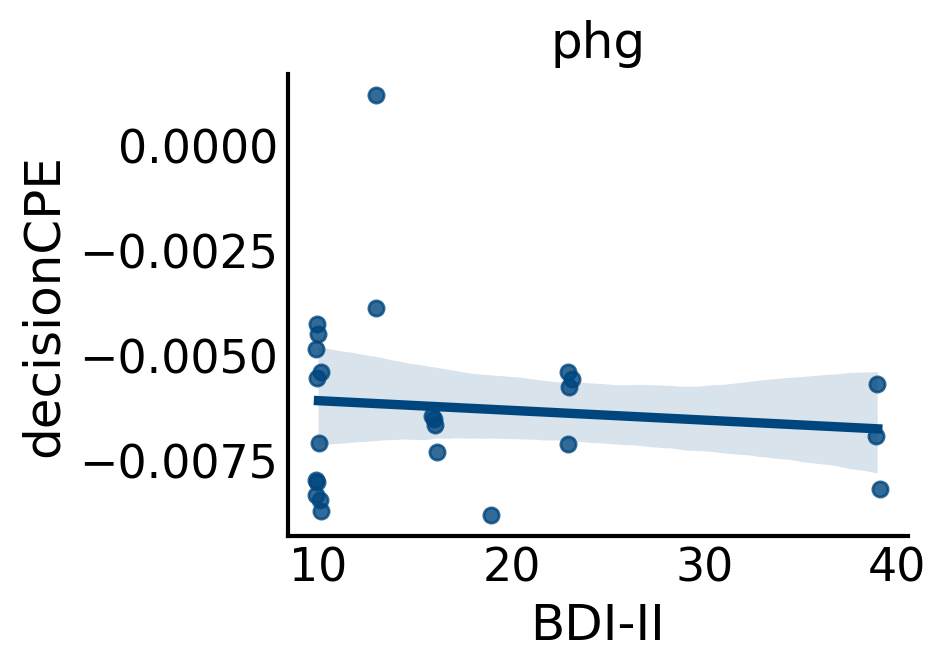

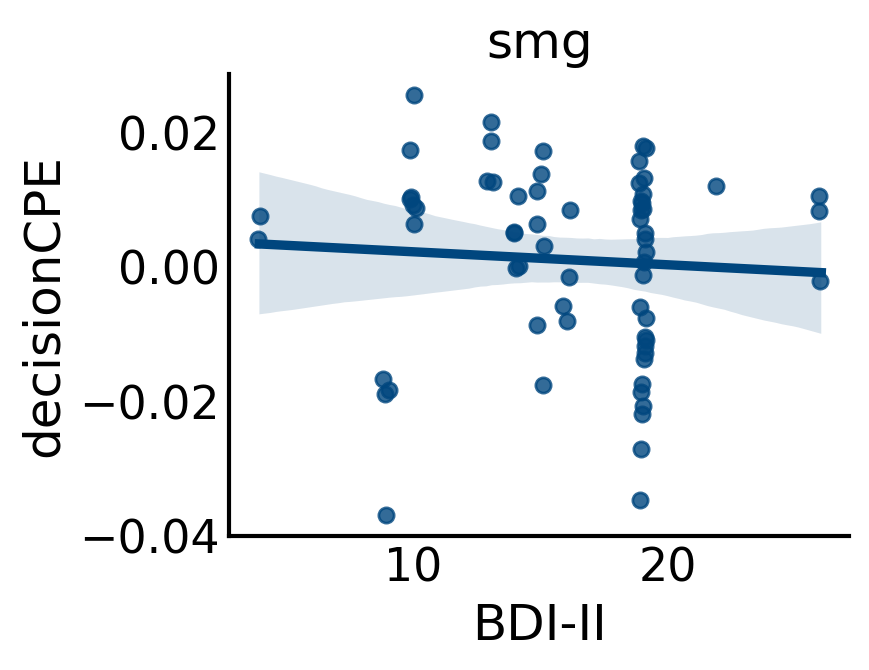

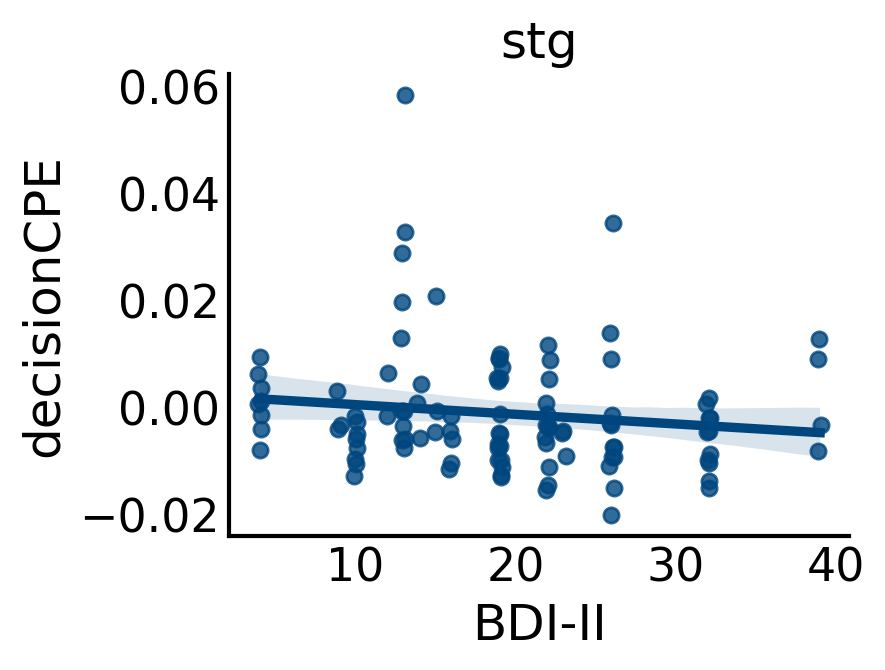

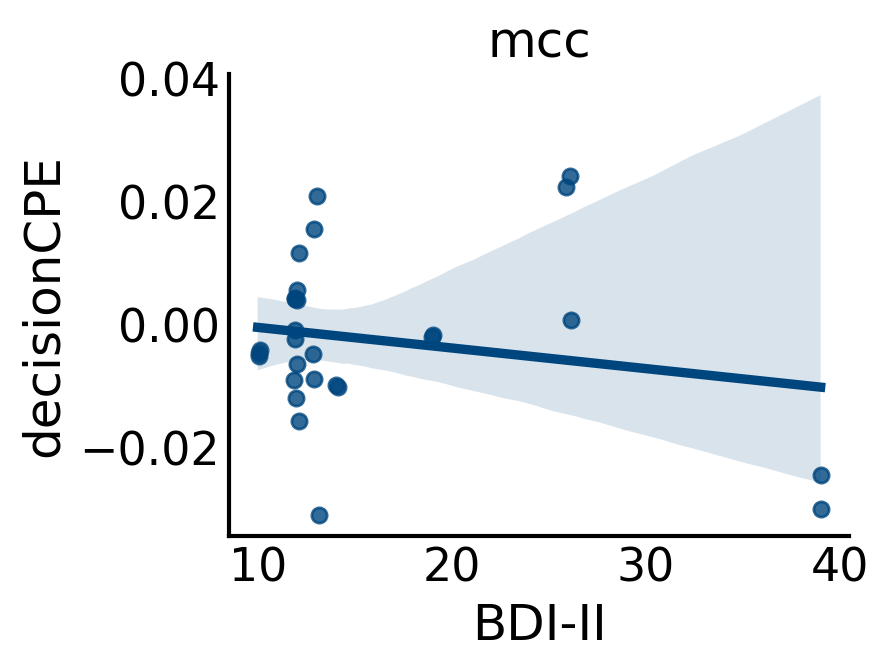

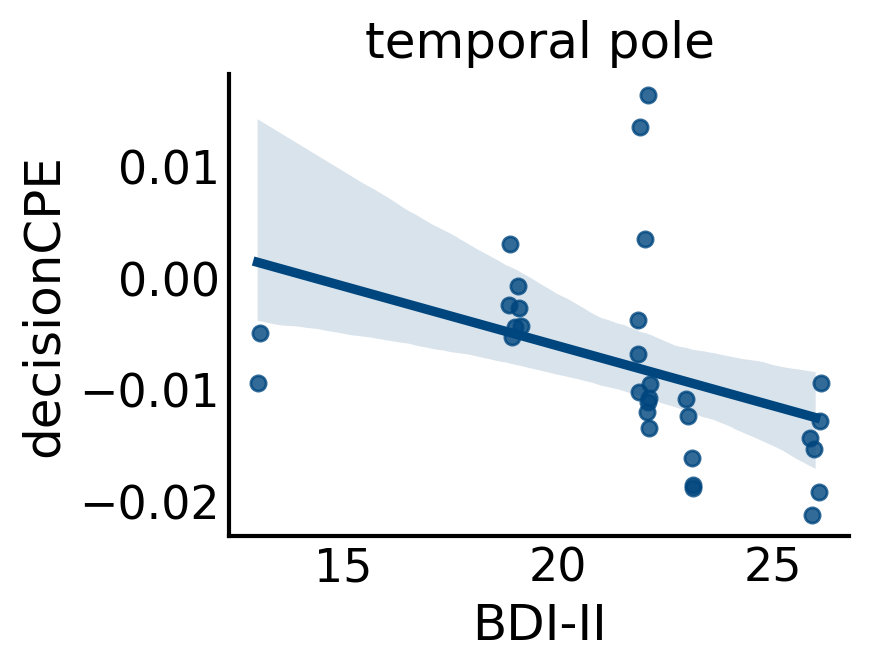

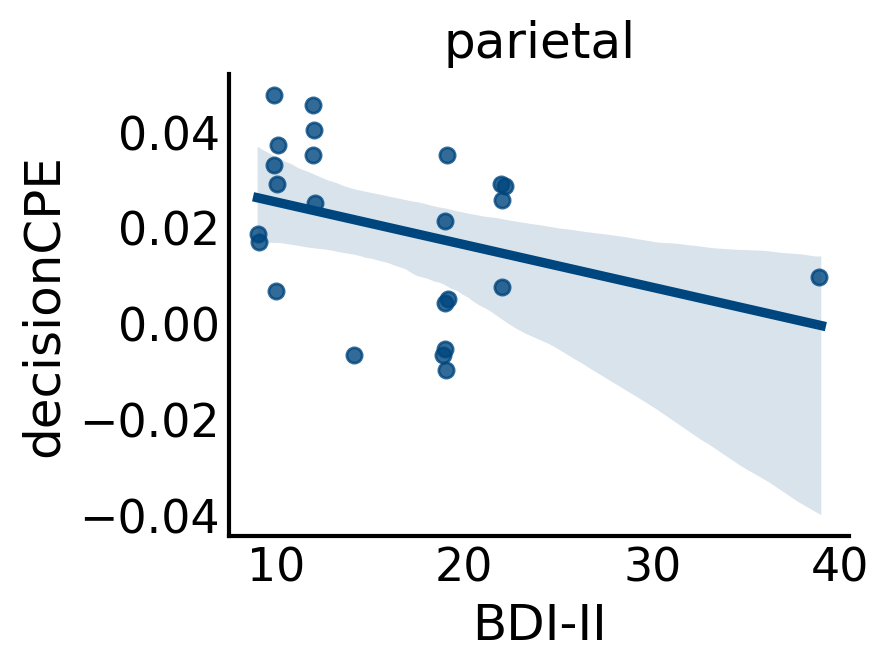

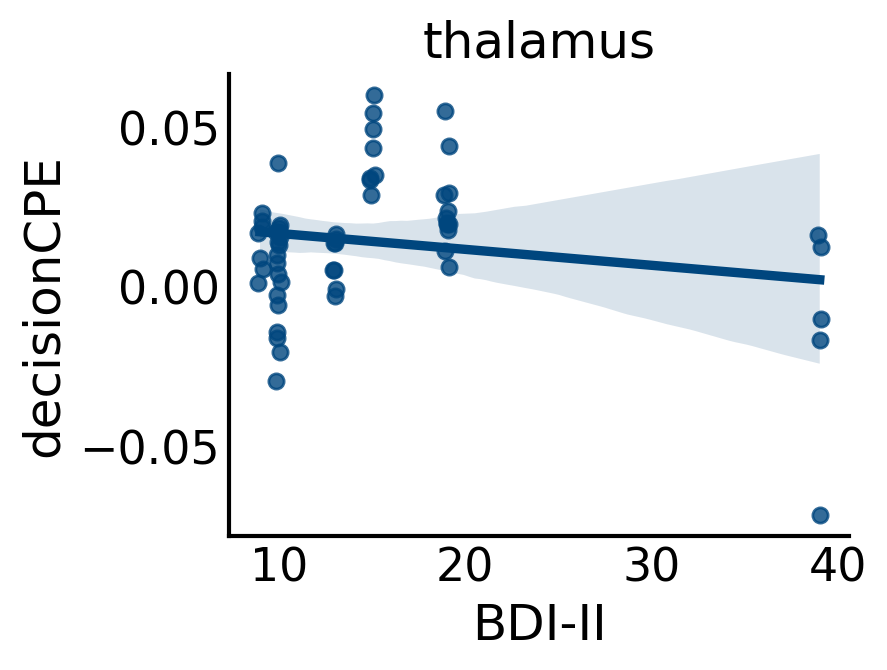

In [49]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = '#00467e',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
# #     plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
# #         bbox_inches='tight', pad_inches=0.1,dpi=300,
# #         facecolor='auto', edgecolor='auto',
# #         backend=None)
    

# RT ~ CPE:Pow Regressions

In [16]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

In [17]:
rt_vars   = ['TrialEV','decisionCPE','band_pow','decisionCPE:band_pow']
rt_fit = fit_mixed_model(reg_df,rt_vars,outcome_var,rand_eff_var,reml=False)
print(rt_fit.summary())
rt_fit.bic    

                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         logRT_t1    
No. Observations:         244112          Method:                     ML          
No. Groups:               1776            Scale:                      0.1319      
Min. group size:          65              Log-Likelihood:             -103686.2255
Max. group size:          148             Converged:                  No          
Mean group size:          137.5                                                   
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                               1.035    0.006 166.159 0.000  1.023  1.047
TrialEV                                 0.016    0.002  10.031 0.000  0.013  0.019
decisionCPE                

207632.96400143547

In [18]:
rt_fit

In [20]:
test_results = mixed_eff_results_df(rt_fit,reg_df)

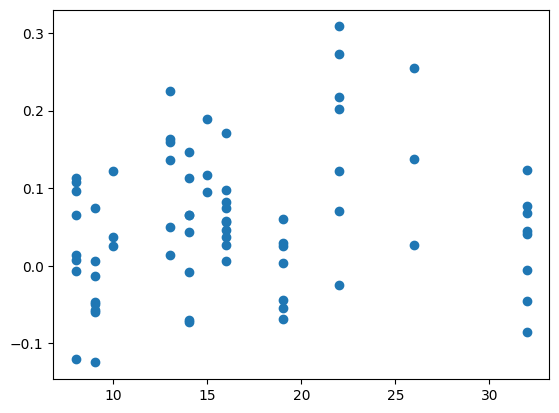

In [22]:
plt.scatter(test_results['bdi'][test_results.roi=='ains'],test_results['decisionCPE:band_pow'][test_results.roi=='ains'])


# ROI REGRESSIONS
- test all ROIs & see which ROIs are significant
- correlate bdi with ROI beta coefficients 


In [70]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'
rt_vars   = ['TrialEV','decisionCPE','band_pow','decisionCPE:band_pow']


In [71]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        rt_vars,outcome_var,rand_eff_var,reml=False) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [72]:
roi_fit_results['band'] = band
roi_fit_results.to_csv(f'{save_dir}RT_{band}_roi_results.csv')

In [73]:
roi_fit_results

unique_reref_ch subj_id       roi  bdi  raw_Intercept  \
0           DA023_lac1-lac2   DA023       acc   14      -0.120574   
1           DA023_lac2-lac3   DA023       acc   14      -0.118794   
2           DA023_lac3-lac4   DA023       acc   14      -0.119107   
3       MS002_lacas1-lacas2   MS002       acc   14      -0.287241   
4       MS002_lacas2-lacas3   MS002       acc   14      -0.286162   
...                     ...     ...       ...  ...            ...   
1771  MS050_lcmang3-lcmang4   MS050  thalamus    9       0.272815   
1772  MS050_lcmang4-lcmang5   MS050  thalamus    9       0.272343   
1773  MS050_rcmsmg1-rcmsmg2   MS050  thalamus    9       0.272417   
1774  MS050_rcmsmg2-rcmsmg3   MS050  thalamus    9       0.272467   
1775  MS050_rcmsmg3-rcmsmg4   MS050  thalamus    9       0.271061   

      raw_TrialEV  raw_decisionCPE  raw_band_pow  raw_decisionCPE:band_pow  \
0        0.008983         0.009784      0.020228                  0.105587   
1        0.009357         0.008447     -0.014369                  0.092530   
2        0.010397         0.007661     -0.058180                  0.018534   
3        0.015914         0.016470      0.053775                 -0.068171   
4        0.016814         0.016643      0.000937                 -0.157744   
...           ...              ...           ...                       ...   
1771    -0.003472         0.039745      0.021628                 -0.028826   
1772    -0.003914         0.042619      0.049977                 -0.140582   
1773    -0.000921         0.040922      0.062122                 -0.074439   
1774    -0.001070         0.041091     -0.037475                 -0.047059   
1775    -0.001727         0.038240     -0.081359                 -0.061199   

      Intercept   TrialEV  decisionCPE  band_pow  decisionCPE:band_pow  band  
0      0.899067  0.021779     0.042418 -0.011549              0.111523  beta  
1      0.900846  0.022153     0.041081 -0.046146              0.098467  beta  
2      0.900533  0.023194     0.040295 -0.089957              0.024470  beta  
3      0.732400  0.028710     0.049103  0.021999             -0.062234  beta  
4      0.733478  0.029610     0.049277 -0.030839             -0.151807  beta  
...         ...       ...          ...       ...                   ...   ...  
1771   1.273874 -0.019033     0.091392  0.042885              0.028206  beta  
1772   1.273401 -0.019475     0.094267  0.071234             -0.083550  beta  
1773   1.273476 -0.016483     0.092570  0.083379             -0.017406  beta  
1774   1.273526 -0.016632     0.092739 -0.016218              0.009973  beta  
1775   1.272120 -0.017288     0.089888 -0.060103             -0.004167  beta  

[1776 rows x 15 columns]

In [74]:
raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results['decisionCPE:band_pow'][roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=1.1108413171571754, pvalue=0.2680258290772177, df=192),
 'dmpfc': TtestResult(statistic=0.11479182498189458, pvalue=0.9087172612004757, df=215),
 'amy': TtestResult(statistic=13.451837734120383, pvalue=3.9288283186188184e-25, df=112),
 'sts': TtestResult(statistic=4.559814302917297, pvalue=1.03779644618615e-05, df=154),
 'ains': TtestResult(statistic=12.877260071381759, pvalue=3.887423195102316e-20, df=70),
 'vlpfc': TtestResult(statistic=-7.444969878503307, pvalue=9.219497113056654e-11, df=81),
 'hpc': TtestResult(statistic=4.614677325335727, pvalue=9.104167828799922e-06, df=134),
 'mtg': TtestResult(statistic=1.2975995596754717, pvalue=0.1997448500319442, df=56),
 'ofc': TtestResult(statistic=2.6122641241277154, pvalue=0.009673688011770825, df=201),
 'pins': TtestResult(statistic=-2.4449453012830773, pvalue=0.017492369303960247, df=59),
 'dlpfc': TtestResult(statistic=-1.4495896050674981, pvalue=0.15012524035161634, df=106),
 'motor': TtestResult(statist

In [75]:
roi_fit_results

unique_reref_ch subj_id       roi  bdi  raw_Intercept  \
0           DA023_lac1-lac2   DA023       acc   14      -0.120574   
1           DA023_lac2-lac3   DA023       acc   14      -0.118794   
2           DA023_lac3-lac4   DA023       acc   14      -0.119107   
3       MS002_lacas1-lacas2   MS002       acc   14      -0.287241   
4       MS002_lacas2-lacas3   MS002       acc   14      -0.286162   
...                     ...     ...       ...  ...            ...   
1771  MS050_lcmang3-lcmang4   MS050  thalamus    9       0.272815   
1772  MS050_lcmang4-lcmang5   MS050  thalamus    9       0.272343   
1773  MS050_rcmsmg1-rcmsmg2   MS050  thalamus    9       0.272417   
1774  MS050_rcmsmg2-rcmsmg3   MS050  thalamus    9       0.272467   
1775  MS050_rcmsmg3-rcmsmg4   MS050  thalamus    9       0.271061   

      raw_TrialEV  raw_decisionCPE  raw_band_pow  raw_decisionCPE:band_pow  \
0        0.008983         0.009784      0.020228                  0.105587   
1        0.009357         0.008447     -0.014369                  0.092530   
2        0.010397         0.007661     -0.058180                  0.018534   
3        0.015914         0.016470      0.053775                 -0.068171   
4        0.016814         0.016643      0.000937                 -0.157744   
...           ...              ...           ...                       ...   
1771    -0.003472         0.039745      0.021628                 -0.028826   
1772    -0.003914         0.042619      0.049977                 -0.140582   
1773    -0.000921         0.040922      0.062122                 -0.074439   
1774    -0.001070         0.041091     -0.037475                 -0.047059   
1775    -0.001727         0.038240     -0.081359                 -0.061199   

      Intercept   TrialEV  decisionCPE  band_pow  decisionCPE:band_pow  band  
0      0.899067  0.021779     0.042418 -0.011549              0.111523  beta  
1      0.900846  0.022153     0.041081 -0.046146              0.098467  beta  
2      0.900533  0.023194     0.040295 -0.089957              0.024470  beta  
3      0.732400  0.028710     0.049103  0.021999             -0.062234  beta  
4      0.733478  0.029610     0.049277 -0.030839             -0.151807  beta  
...         ...       ...          ...       ...                   ...   ...  
1771   1.273874 -0.019033     0.091392  0.042885              0.028206  beta  
1772   1.273401 -0.019475     0.094267  0.071234             -0.083550  beta  
1773   1.273476 -0.016483     0.092570  0.083379             -0.017406  beta  
1774   1.273526 -0.016632     0.092739 -0.016218              0.009973  beta  
1775   1.272120 -0.017288     0.089888 -0.060103             -0.004167  beta  

[1776 rows x 15 columns]

In [76]:
fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
# fe_params_pvals = {f'{roi}':roi_fit_dict[roi].pvalues for roi in list(roi_fit_dict.keys())}


In [77]:
fe_results = []
for fe_res in fe_params_results:
    
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))


In [78]:
fe_results = pd.concat(fe_results).reset_index(drop=True)

In [79]:
fe_results['roi_cpepow_pval'] = [roi_fit_dict[roi].pvalues['decisionCPE:band_pow'] for roi in fe_results.roi.tolist()]


In [82]:
fe_results

Intercept   TrialEV  decisionCPE  band_pow  decisionCPE:band_pow  \
0    1.019640  0.012796     0.032634 -0.031777              0.005937   
1    0.992301  0.019317     0.047678 -0.058851              0.000640   
2    1.037969  0.021120     0.042827 -0.040206              0.041381   
3    1.043673  0.019328     0.025749 -0.048072              0.023810   
4    0.998714  0.018579     0.047903 -0.016047              0.119243   
5    1.018651  0.039407     0.032543 -0.025962             -0.064734   
6    0.995682  0.012201     0.037013 -0.021790              0.014526   
7    1.086726  0.013462     0.049876 -0.011179              0.011107   
8    1.038803  0.015527     0.039862 -0.035680              0.019516   
9    1.100266  0.029721     0.025622 -0.009073             -0.034073   
10   1.029125  0.010920     0.043110 -0.041282             -0.010050   
11   1.164267  0.020888    -0.001716 -0.038248             -0.120435   
12   1.046851  0.007074     0.077556 -0.035274              0.021513   
13   0.884774 -0.011807     0.058061 -0.117621             -0.002417   
14   1.130826  0.000443     0.019092 -0.047195              0.149056   
15   1.033292  0.018675     0.044730 -0.036092              0.017781   
16   1.080392  0.004736     0.038772 -0.003976              0.032553   
17   1.141824  0.011256     0.008687 -0.136583              0.049667   
18   1.223255  0.027831     0.031429  0.057404              0.001987   
19   1.001059 -0.015561     0.051648  0.021257              0.057033   

              roi  roi_cpepow_pval  
0             acc         0.856840  
1           dmpfc         0.981468  
2             amy         0.224715  
3             sts         0.321113  
4            ains         0.011111  
5           vlpfc         0.087115  
6             hpc         0.560010  
7             mtg         0.816449  
8             ofc         0.500487  
9            pins         0.423523  
10          dlpfc         0.786823  
11          motor         0.092257  
12          vmpfc         0.813071  
13            phg         0.978724  
14            smg         0.000575  
15            stg         0.576135  
16            mcc         0.628069  
17  temporal pole         0.452646  
18       parietal         0.973880  
19       thalamus         0.240857

In [63]:
bonferr_alpha = 0.05/len(fe_results)
bonferr_alpha

0.0025

In [81]:
sig_rois = fe_results.roi[fe_results.roi_cpepow_pval <= bonferr_alpha].tolist()
sig_rois

['smg']

In [65]:
# plot_roi_model_results(roi_fit_results,'roi','decisionCPE:band_pow')


#function info - 
# plot_roi_model_results(model_results,x_var,y_var,ylabel=None,color = 'k',bar_order=None,figsize=(10,4),dpi=500,linewidth=1.5,
#                            size=6,sns_context="poster",save_fig=False,save_dir=None,fig_id=None)


In [ ]:
# # plot ROI beta distribution
# sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# plt.title(f'ACC n={n}')

# sns.despine()

In [83]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data['decisionCPE:band_pow'])
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr -0.00695113476095614 0.923566562294495
dmpfc pearsonr 0.17728161542402698 0.009025313834057106
amy pearsonr 0.4066000778643228 7.866050029934052e-06
sts pearsonr 0.07270768343512371 0.3686170994468124
ains pearsonr 0.10329247610473659 0.3913315227761974
vlpfc pearsonr -0.34303338185460763 0.0016053883700462524
hpc pearsonr 0.25834103535732567 0.0024841332265052164
mtg pearsonr -0.022685269882267507 0.8669789238357062
ofc pearsonr 0.05495318773700242 0.43729341879689554
pins pearsonr -0.0323350781213009 0.8062537855443113
dlpfc pearsonr -0.12303650868321525 0.20674947083157957
motor pearsonr -0.34324584427650734 0.09298787891460764
vmpfc pearsonr -0.3022685394204471 0.1609650860720783
phg pearsonr -0.24919875679285883 0.2296470460494809
smg pearsonr -0.22272795875406634 0.0722513322071549
stg pearsonr -0.29684625973877155 0.002105153503673454
mcc pearsonr -0.39877108054430577 0.03555490691067585
temporal pole pearsonr -0.2087726671081335 0.2596983372944954
parietal pearsonr

In [84]:
sig_rho

[('dmpfc', 0.17728161542402698, 0.009025313834057106),
 ('amy', 0.4066000778643228, 7.866050029934052e-06),
 ('vlpfc', -0.34303338185460763, 0.0016053883700462524),
 ('hpc', 0.25834103535732567, 0.0024841332265052164),
 ('stg', -0.29684625973877155, 0.002105153503673454),
 ('mcc', -0.39877108054430577, 0.03555490691067585),
 ('parietal', -0.6514235418450631, 0.0005645301887789525)]

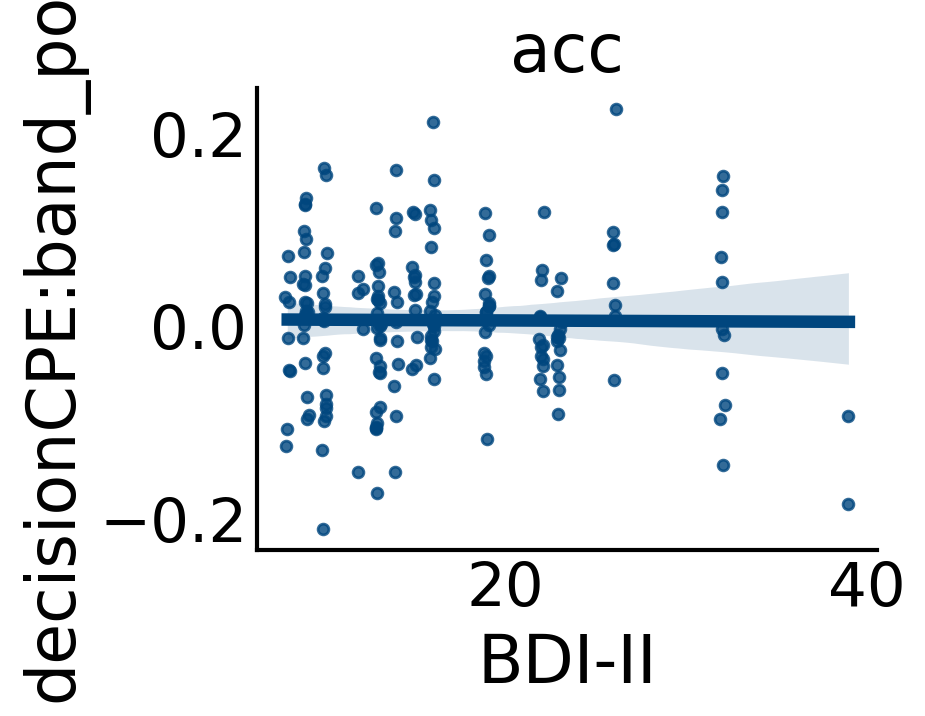

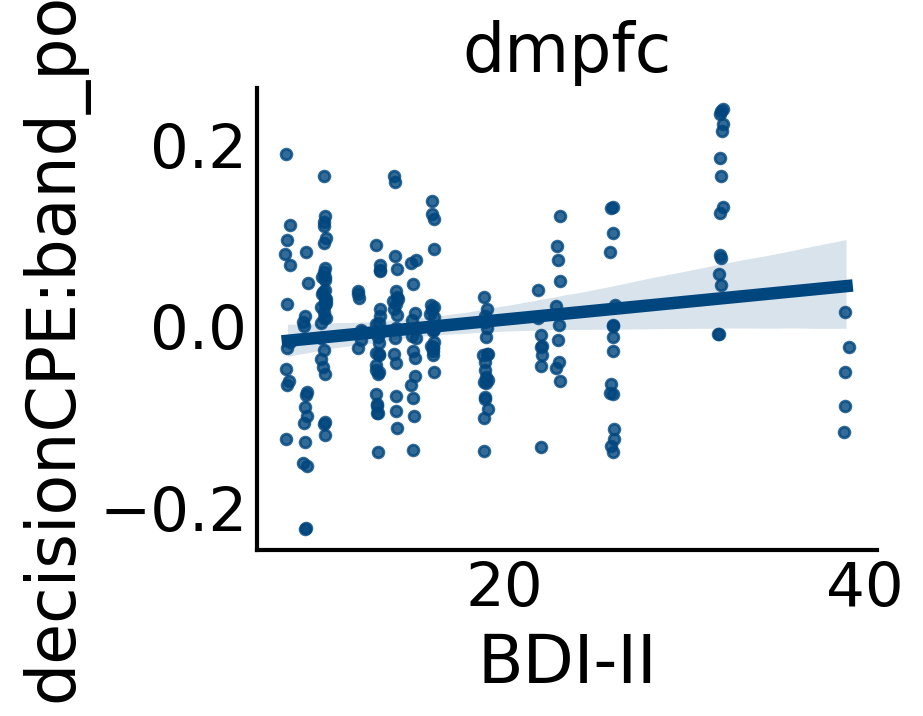

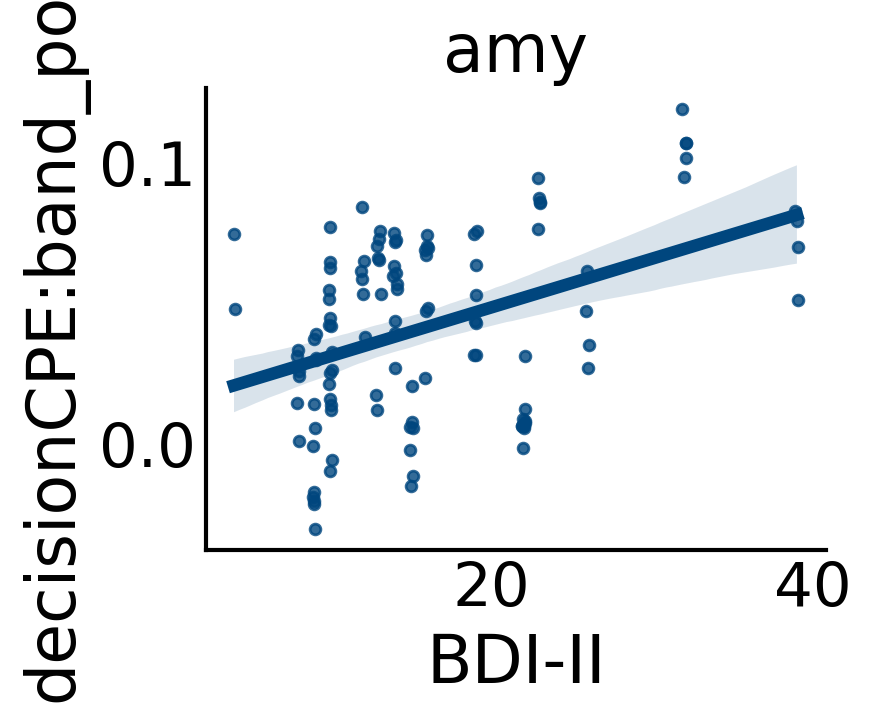

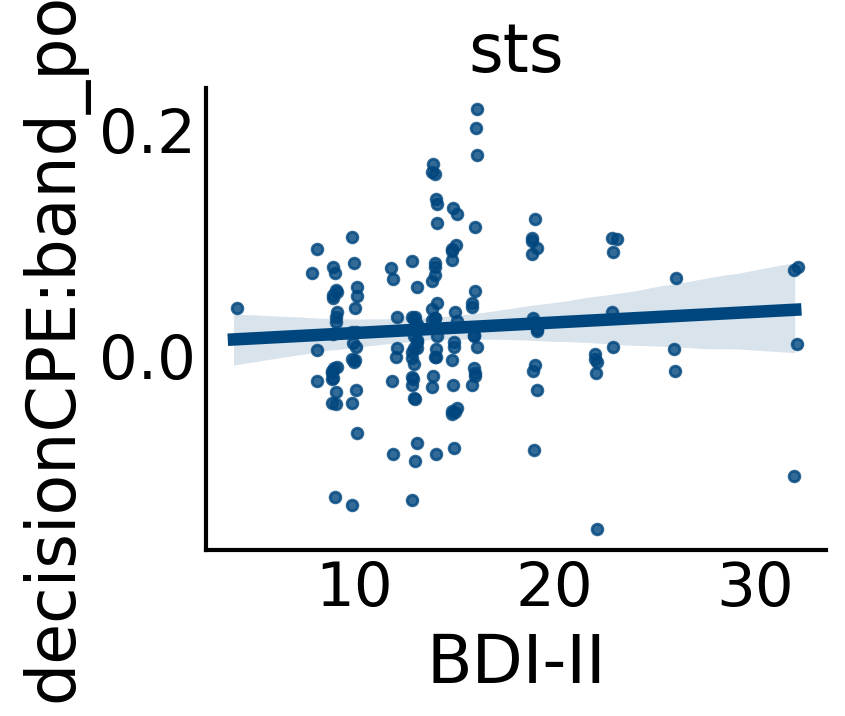

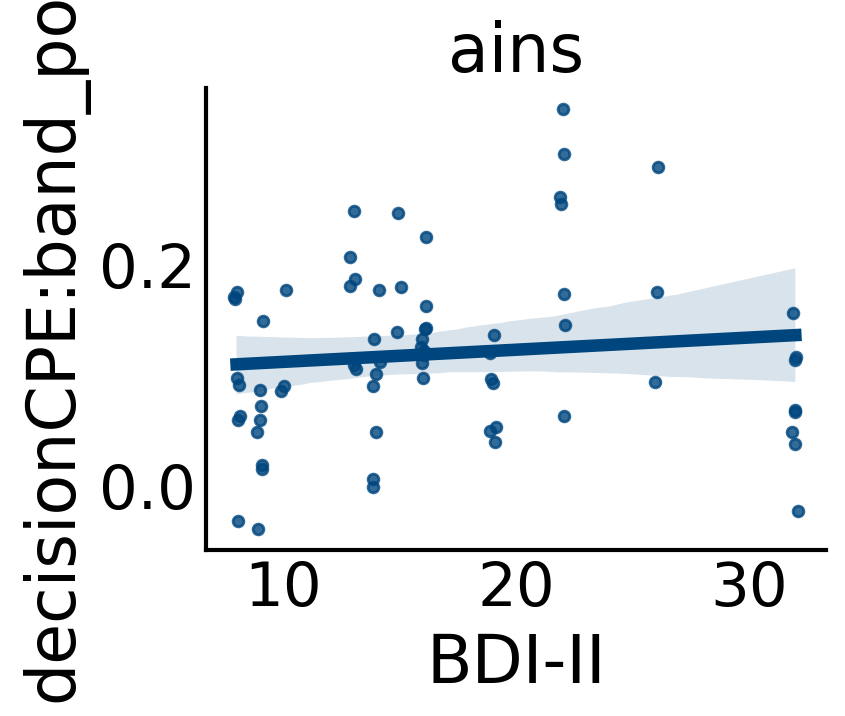

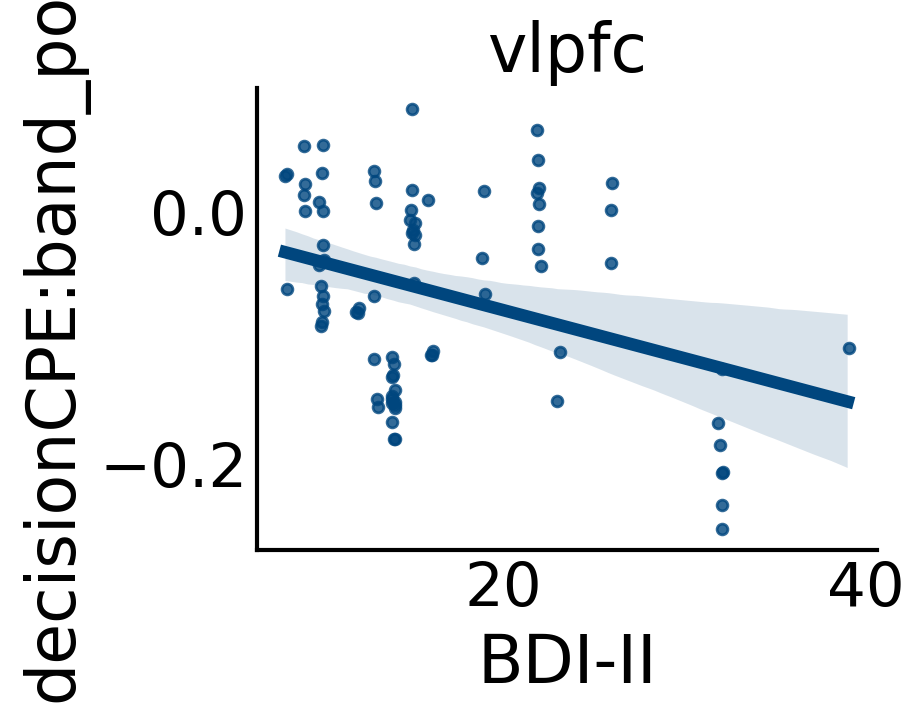

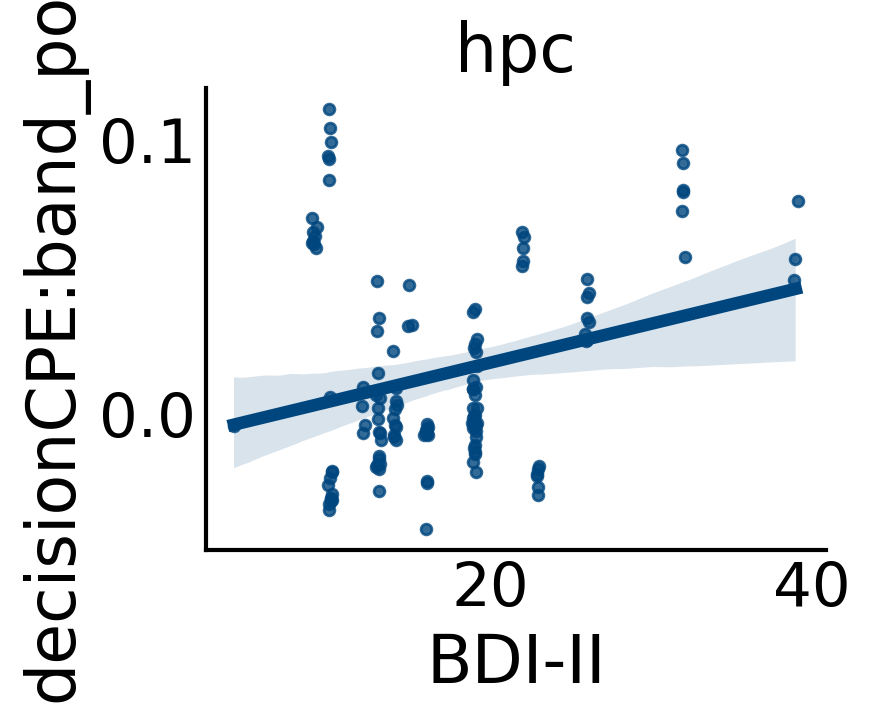

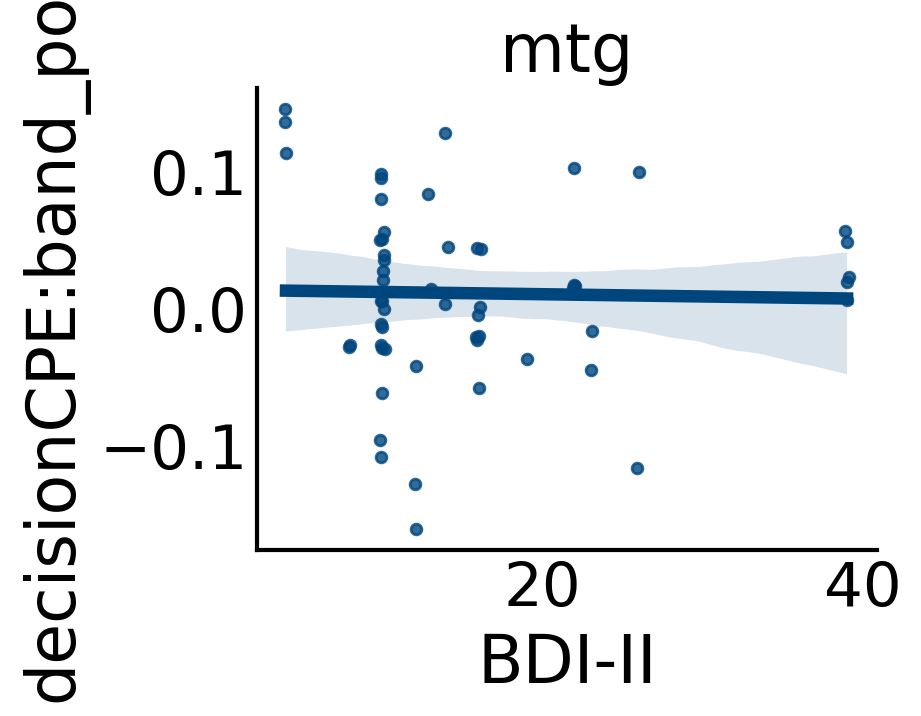

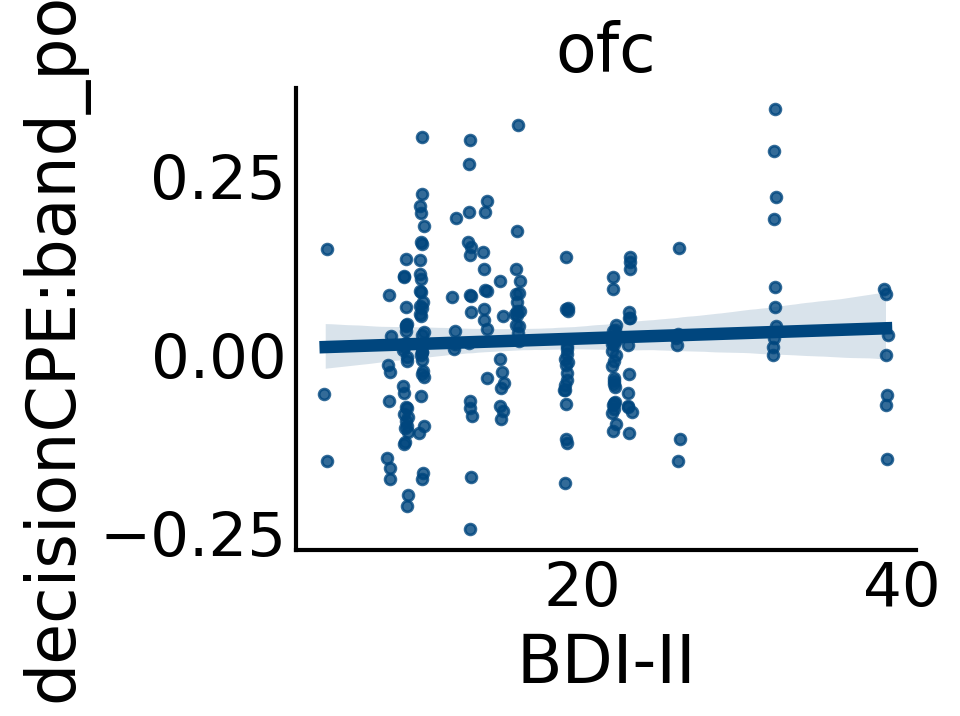

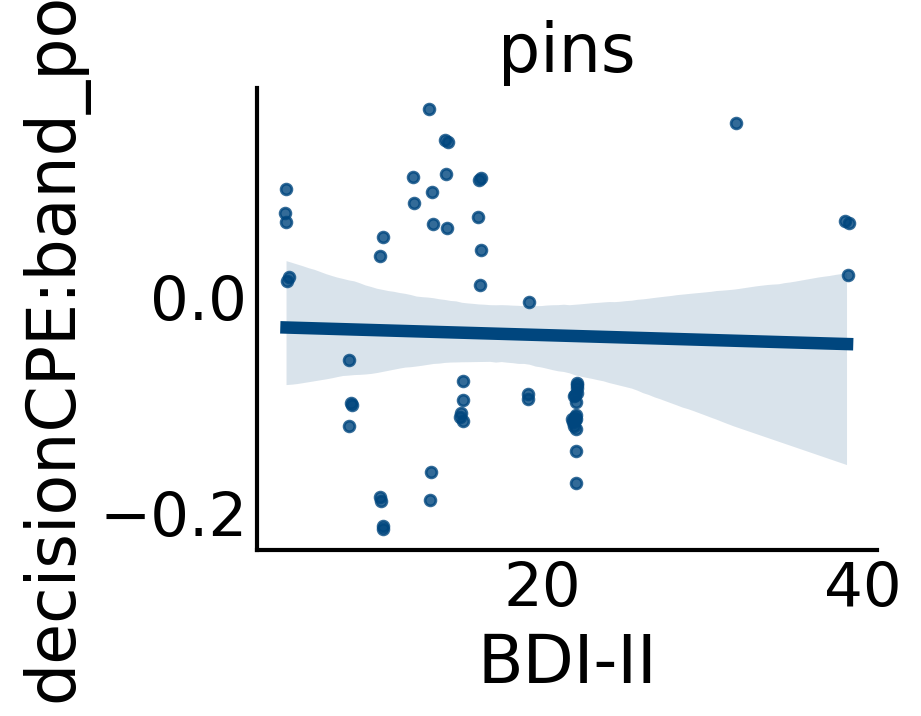

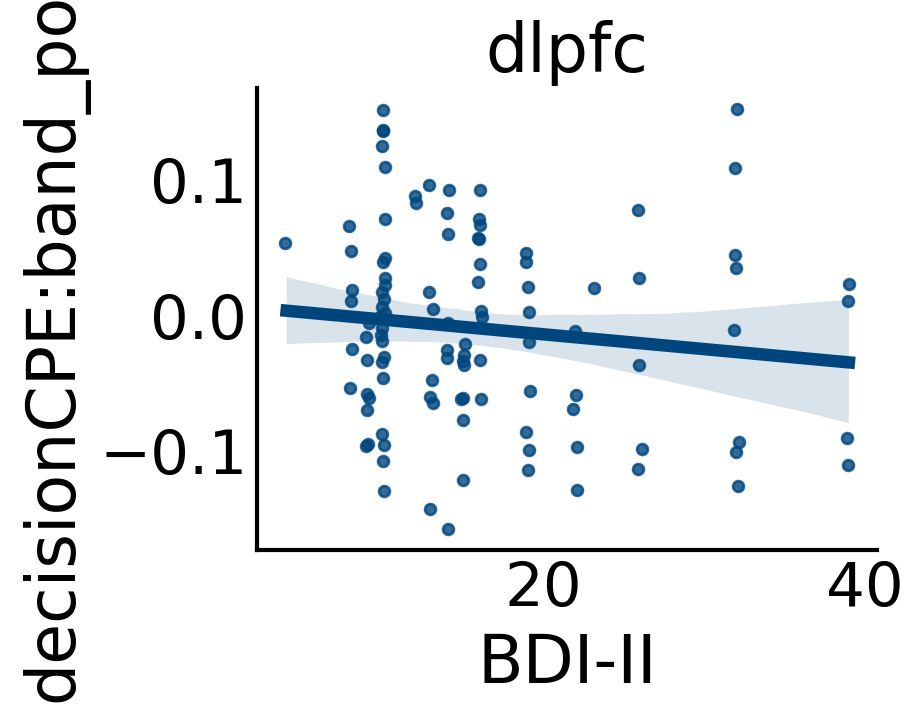

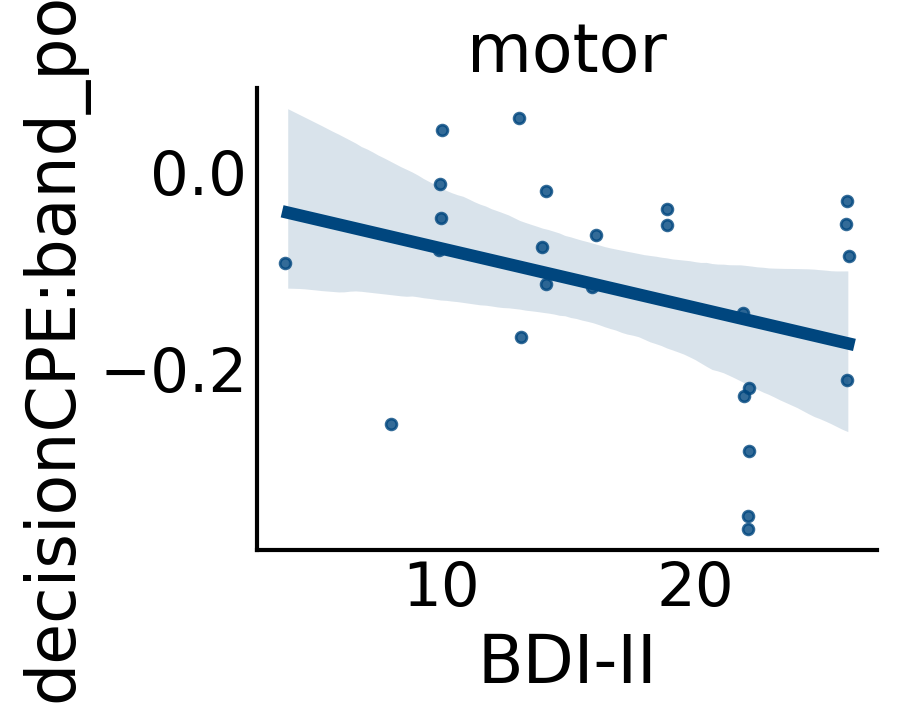

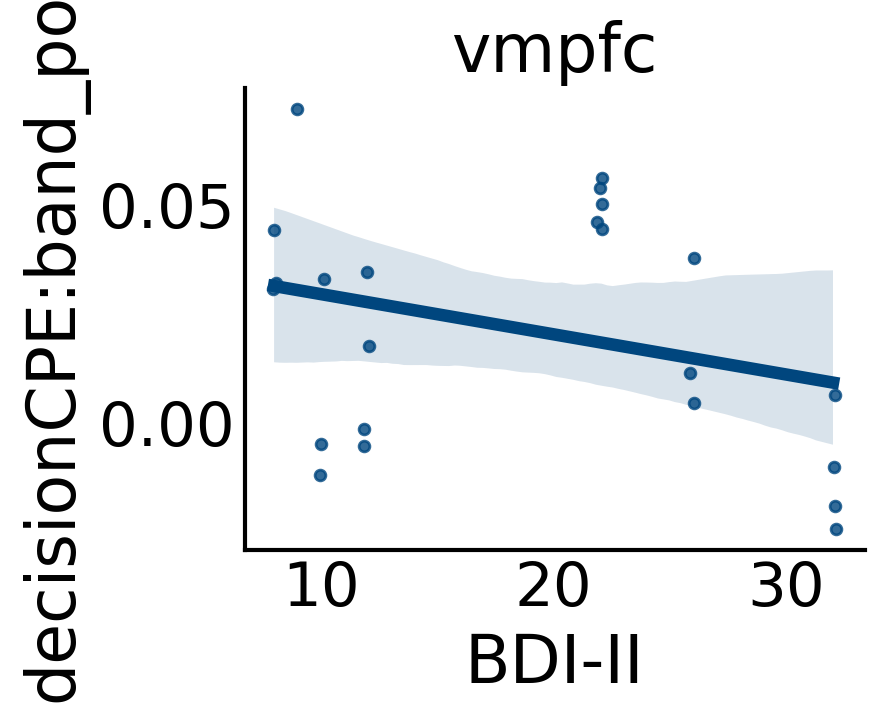

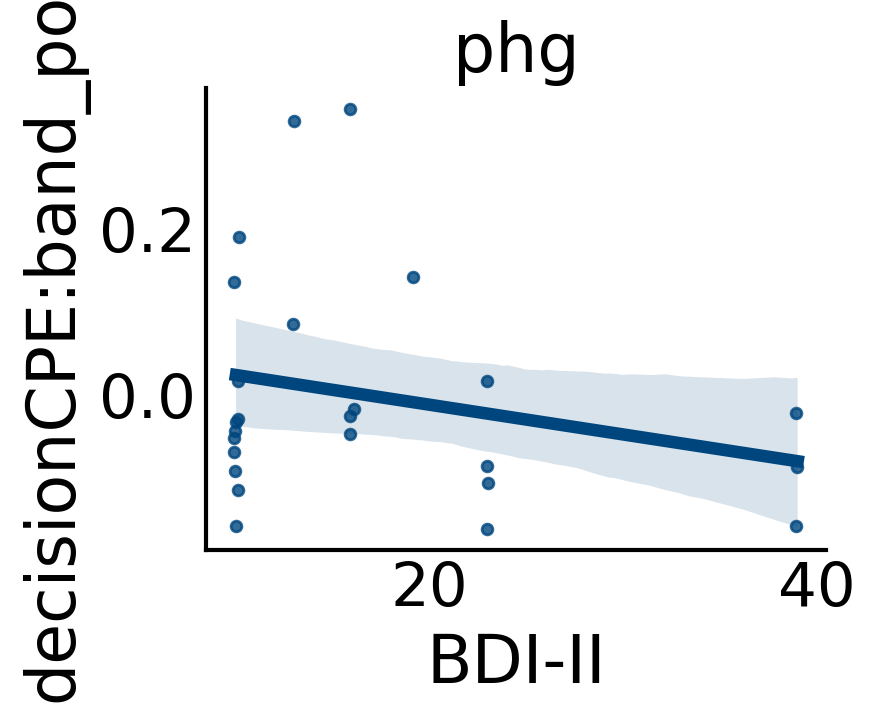

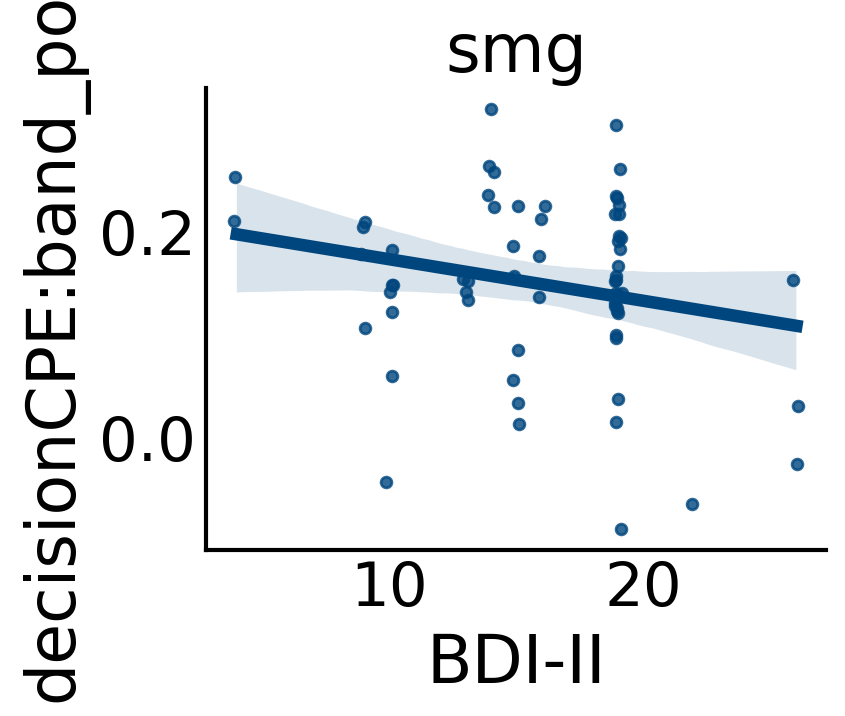

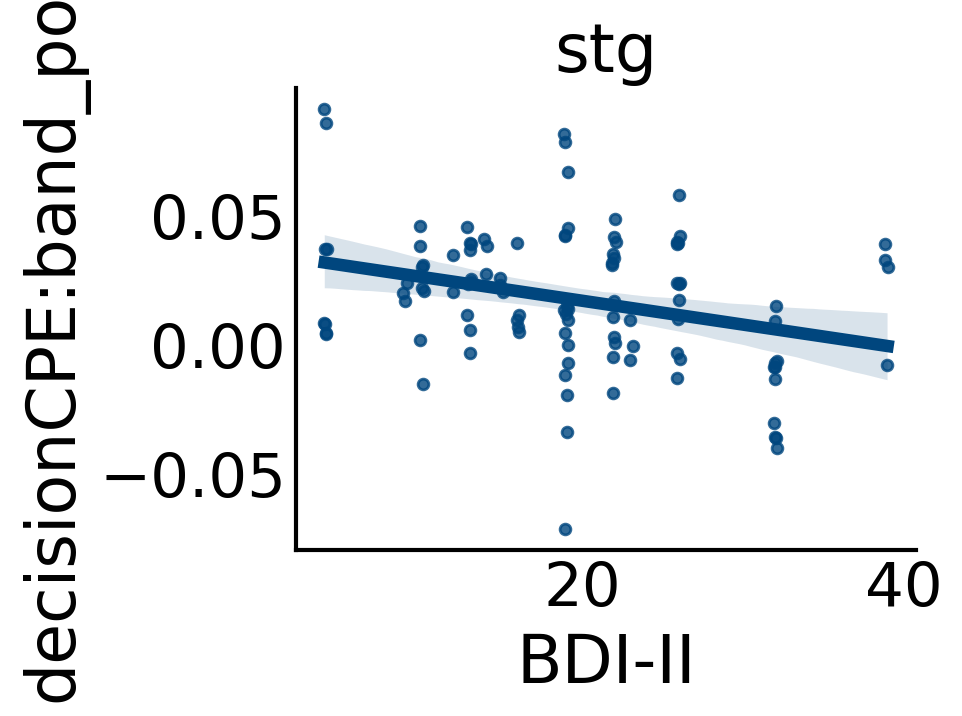

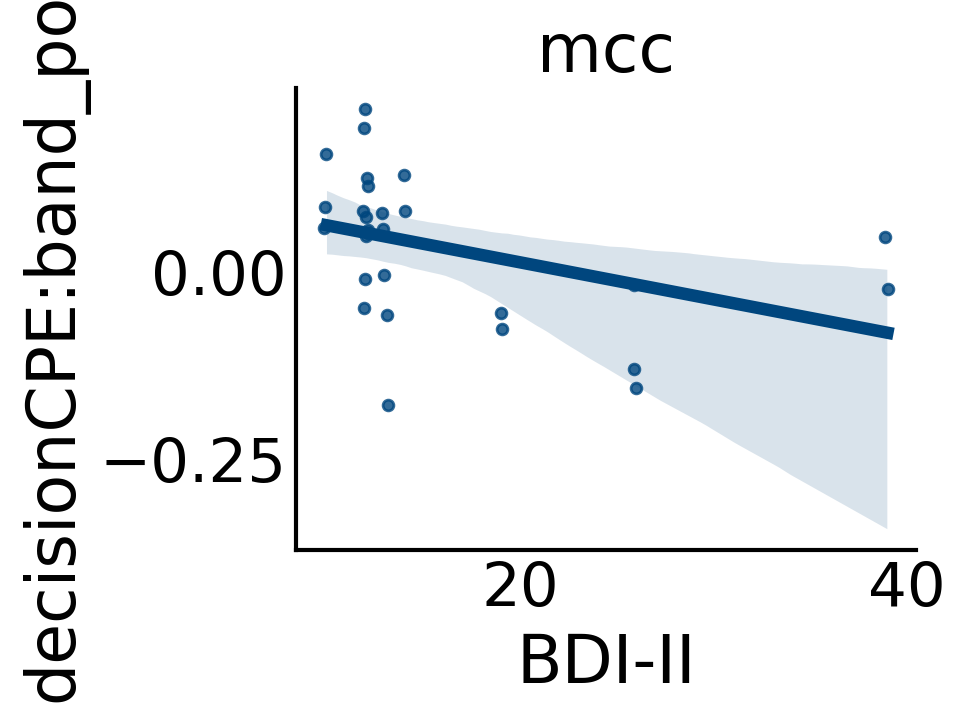

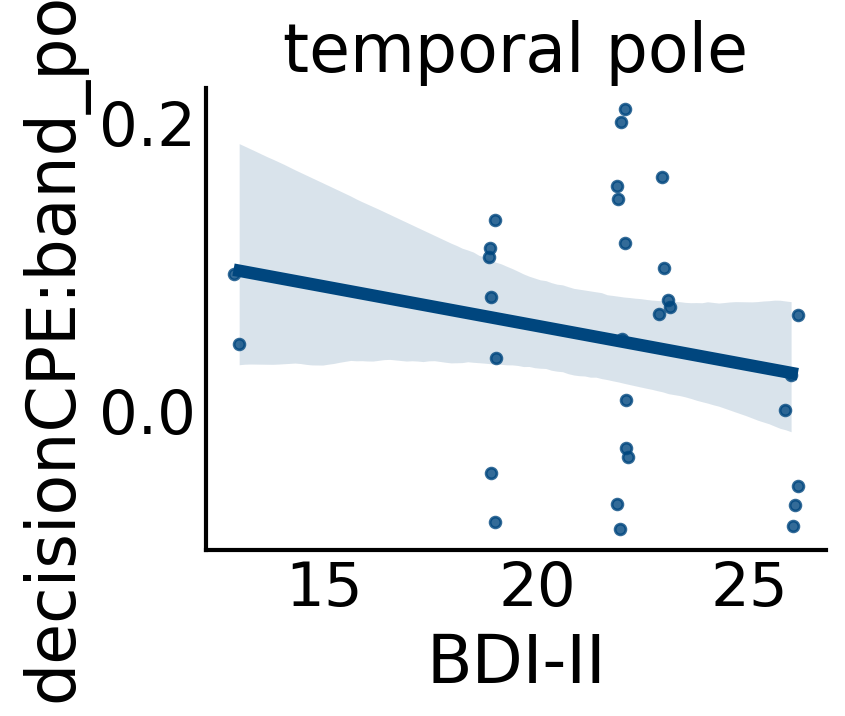

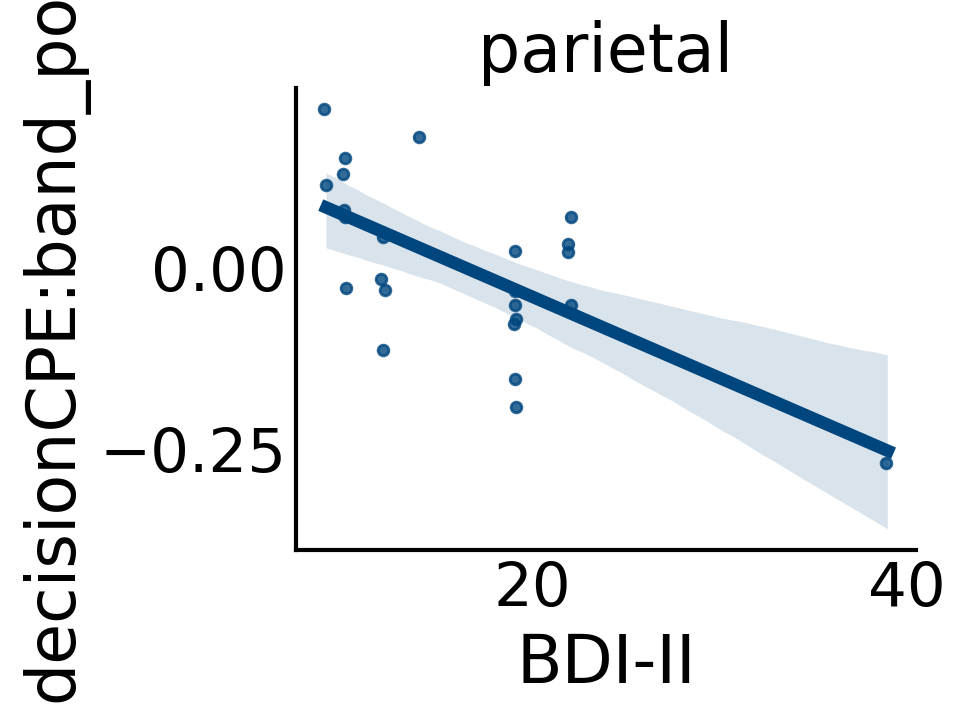

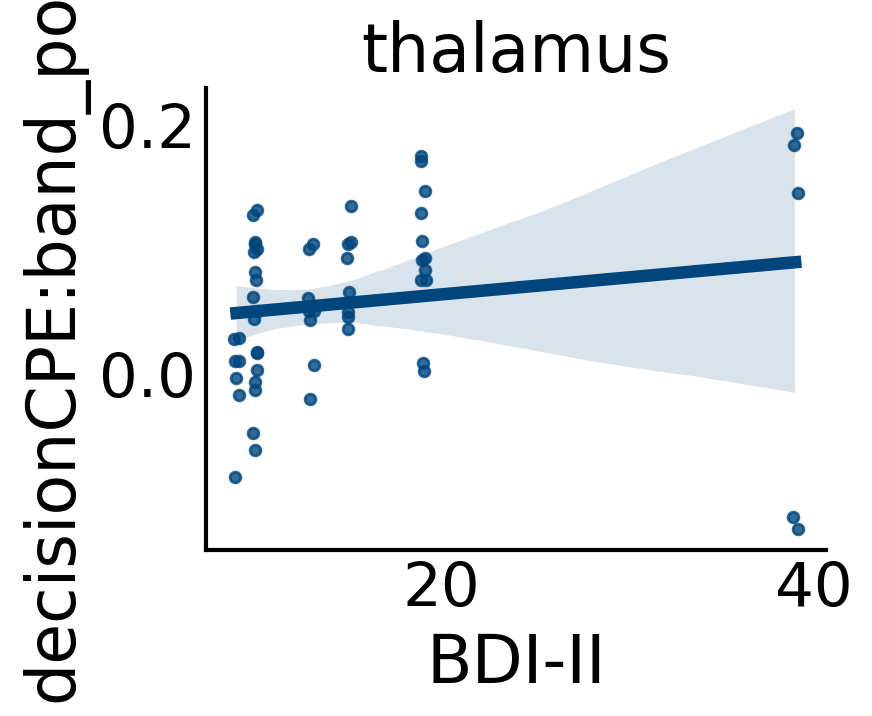

In [85]:

sns.set_context("poster",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='decisionCPE:band_pow',scatter=True,ci=95,
                fit_reg=True,color = '#00467e',x_jitter = 0.15,scatter_kws={'s':15}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
# #     plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
# #         bbox_inches='tight', pad_inches=0.1,dpi=300,
# #         facecolor='auto', edgecolor='auto',
# #         backend=None)
    